In [1]:
# !/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on 20181217

@author: zhangji
"""

%pylab inline
pylab.rcParams['figure.figsize'] = (25, 11)
fontsize = 40

from time import time
import os
import glob
import numpy as np
import scipy as sp
import scipy.misc
import pandas as pd
import re
from scanf import scanf
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.mplot3d import Axes3D, axes3d
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from scipy.optimize import leastsq, curve_fit
from scipy.interpolate import interp1d
from scipy.io import loadmat, savemat
from IPython.display import display, HTML
from scipy import interpolate
from matplotlib import animation, rc
from IPython.display import HTML
rc('animation', html='html5')
from tqdm import tqdm_notebook as tqdm
import natsort 
from shutil import copyfile

from src import jeffery_model as jm
from codeStore import support_fun as spf
from src.support_class import *

PWD = os.getcwd()
font = {'size': 20}
matplotlib.rc('font', **font)
np.set_printoptions(linewidth=90, precision=5)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def set_axes_equal(ax):
    if  ax.name == "3d":
        '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
        cubes as cubes, etc..  This is one possible solution to Matplotlib's
        ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

        Input
          ax: a matplotlib axis, e.g., as output from plt.gca().
        '''

        limits = np.array([
            ax.get_xlim3d(),
            ax.get_ylim3d(),
            ax.get_zlim3d(),
        ])

        origin = np.mean(limits, axis=1)
        radius = 0.6 * np.max(np.abs(limits[:, 1] - limits[:, 0]))
        ax.set_xlim3d([origin[0] - radius, origin[0] + radius])
        ax.set_ylim3d([origin[1] - radius, origin[1] + radius])
        ax.set_zlim3d([origin[2] - radius, origin[2] + radius])
    else:
        limits = np.array([
            ax.get_xlim(),
            ax.get_ylim(),
        ])

        origin = np.mean(limits, axis=1)
        radius = 0.6 * np.max(np.abs(limits[:, 1] - limits[:, 0]))
        ax.set_xlim([origin[0] - radius, origin[0] + radius])
        ax.set_ylim([origin[1] - radius, origin[1] + radius])


In [3]:
def read_helix_data(dir_name, file_handle, readLength=None):
    t_dir = os.path.join(PWD, dir_name, file_handle)
    mat_names = natsort.natsorted(glob.glob('%s/%s_*.mat' % (t_dir, file_handle)))
    if readLength is None:
        readLength = len(mat_names)
    ecoli_U_list = []
    ecoli_norm_list = []
    ecoli_center_list = []
    ecoli_nodes_list = []
    ecoli_u_list = []
    ecoli_f_list = []
    ecoli_t_list = []
    for mati in mat_names[:readLength]:
        mat_contents = loadmat(mati)
        ecoli_U = mat_contents['ecoli_U'].flatten()
        ecoli_norm = mat_contents['ecoli_norm'].flatten()
        ecoli_center = mat_contents['ecoli_center'].flatten()
        ecoli_t = mat_contents['ti'].flatten()
        ecoli_nodes = mat_contents['ecoli_nodes']
        ecoli_u = mat_contents['ecoli_u']
        ecoli_f = mat_contents['ecoli_f']
        ecoli_U_list.append(ecoli_U)
        ecoli_norm_list.append(ecoli_norm)
        ecoli_center_list.append(ecoli_center)
        ecoli_nodes_list.append(ecoli_nodes)
        ecoli_t_list.append(ecoli_t)
    #     ecoli_u_list.append(ecoli_u)
    #     ecoli_f_list.append(ecoli_f)
    #     set_axes_equal(ax)

    ecoli_U = np.vstack(ecoli_U_list)
    ecoli_norm = np.vstack(ecoli_norm_list)
    ecoli_center = np.vstack(ecoli_center_list)
    ecoli_t = np.hstack(ecoli_t_list)
    print(dir_name, file_handle, ecoli_t.size)
    return ecoli_U, ecoli_norm, ecoli_center, ecoli_t, ecoli_nodes_list

motion_helix_passive1 hlx_prl_ch15 2740


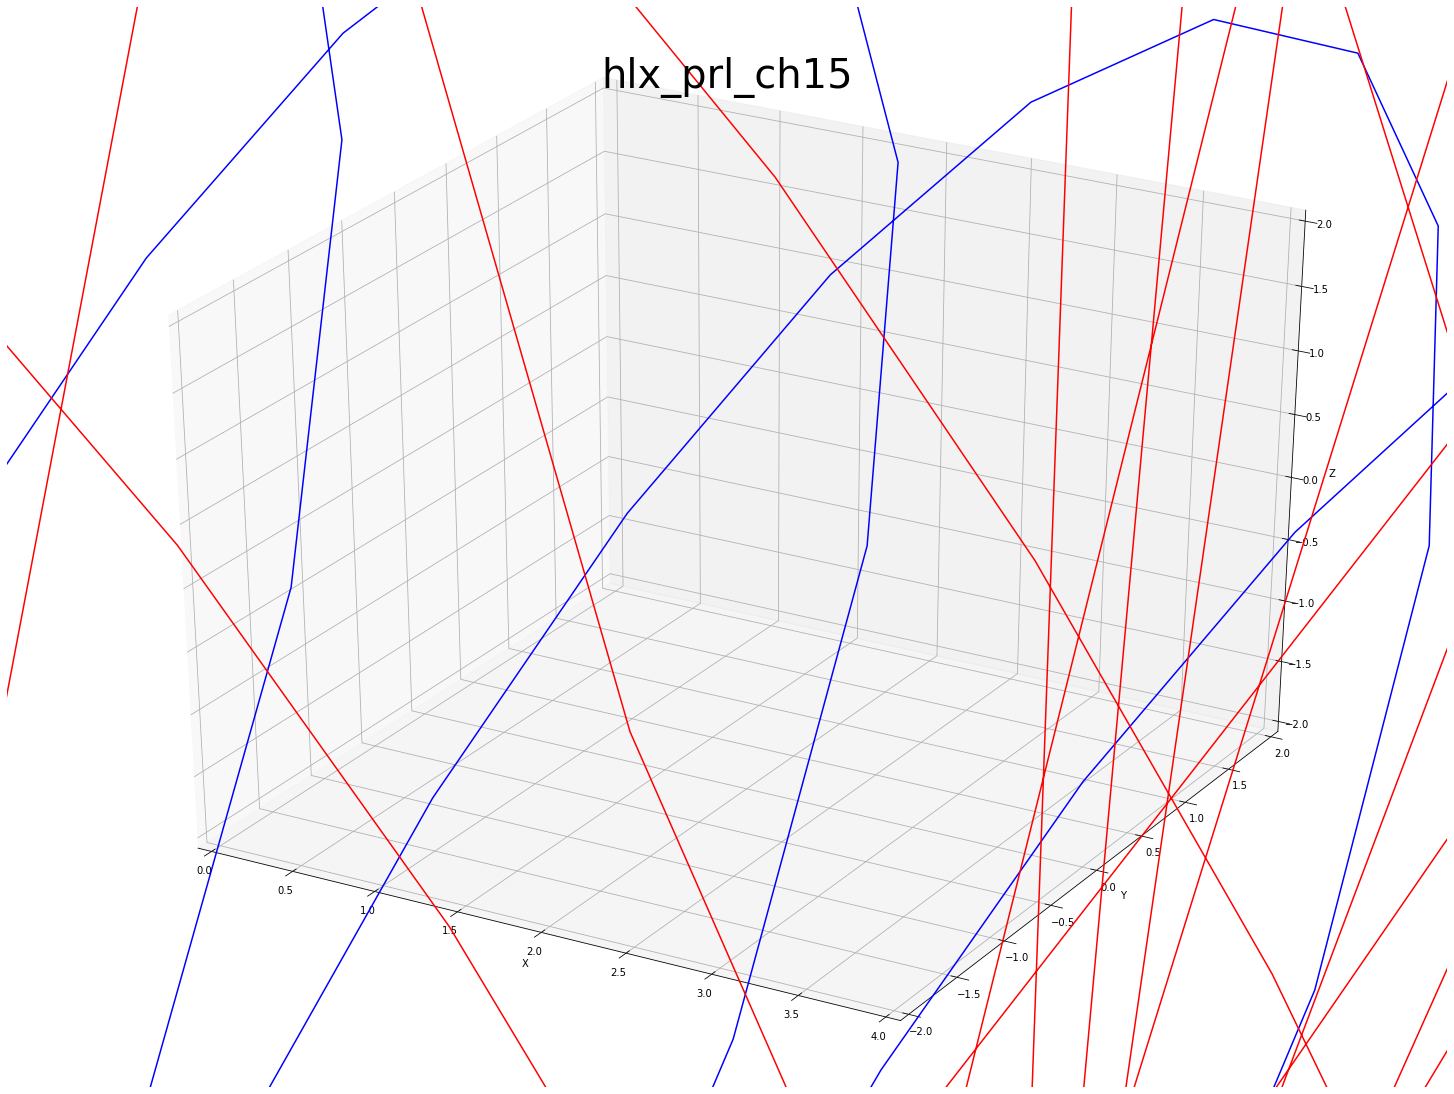

In [32]:
# dir_name = 'motion_helix_passive1'
# file_handle = 'hlx_tau01.00'
# anim_step = 1

# dir_name = 'motion_ecoli_torque6'
# file_handle = 'passive_tau01.00'
# anim_step = 1

# dir_name = 'motion_helix_passive2b'
# file_handle = 'hlx_ntail1'

dir_name = 'motion_helix_passive1'
file_handle = 'hlx_prl_ch15'

# dir_name = 'motion_helix_passive2c'
# file_handle = 'hlx_ntail1_theta0.15_phi4.34_t0.1'

anim_step = 1
tmp = scanf('hlx_ntail%d', file_handle)
n_tail = 1 if tmp is None else tmp[0]
ecoli_U, ecoli_norm, ecoli_center, ecoli_t, ecoli_nodes_list = read_helix_data(dir_name, file_handle)
ecoli_theta = np.arccos(ecoli_norm[:, 2] / np.linalg.norm(ecoli_norm, axis=1))
t_phi = np.arctan2(ecoli_norm[:, 1], ecoli_norm[:, 0])
ecoli_phi = np.hstack([t1 + 2 * np.pi if t1 < 0 else t1 for t1 in t_phi])

fig = plt.figure(figsize=(20, 15))
fig.patch.set_facecolor('white')
ax = axes3d.Axes3D(fig)
for spine in ax.spines.values():
    spine.set_visible(False)

Writer = animation.writers['ffmpeg']
writer = Writer(fps=25, bitrate=1800, metadata=dict(artist='ZhangJi', title=file_handle, copyright='MIT'))
t0 = np.split(ecoli_nodes_list[0], 2 * n_tail)
t1 = np.vstack(t0[0::2])
t2 = np.vstack(t0[1::2])
tl1 = ax.plot(t1[:, 0], t1[:, 1], t1[:, 2], color='b')[0]
tl2 = ax.plot(t2[:, 0], t2[:, 1], t2[:, 2], color='r')[0]
ax.set_xlim3d([0, 4])
ax.set_xlabel('X')
ax.set_ylim3d([-2, 2])
ax.set_ylabel('Y')
ax.set_zlim3d([-2, 2])
ax.set_zlabel('Z')
ax.set_title(file_handle, size=fontsize)

def update_fun(num, tl1, tl2, ecoli_nodes_list):
    num = num * anim_step
    t0 = np.split(ecoli_nodes_list[num], 2 * n_tail)
    t1 = np.vstack(t0[0::2])
    t2 = np.vstack(t0[1::2])
    tl1.set_data(t1[:, 0], t1[:, 1])
    tl1.set_3d_properties(t1[:, 2])
    tl2.set_data(t2[:, 0], t2[:, 1])
    tl2.set_3d_properties(t2[:, 2])
    return tl1, tl2, 

# line_ani = animation.FuncAnimation(fig, update_fun, len(ecoli_nodes_list) // anim_step, interval=50, 
#                                    blit=False, fargs=(tl1, tl2, ecoli_nodes_list, ),)
# line_ani.save(os.path.join(PWD, dir_name, file_handle + '.mp4'), writer=writer)
# line_ani
pass


In [33]:
print(ecoli_theta[-1], ecoli_phi[-1])

1.56958829509 1.57486732341


[  2.93700e-01   5.01406e-05   9.55898e-01]


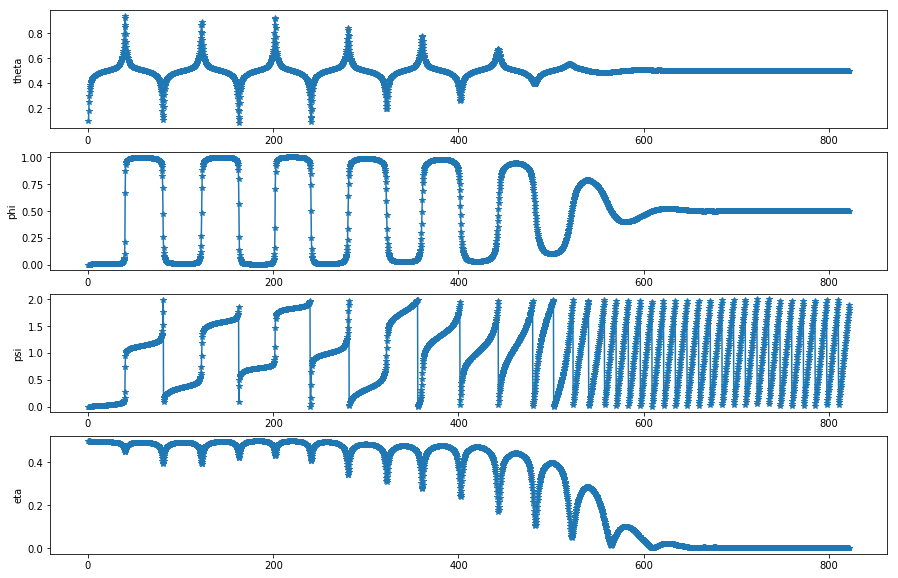

In [34]:
# calculate psi and lateral norm. 
# def get_rot_matrix(norm=np.array([0, 0, 1]), theta=0):
#     norm = np.array(norm).reshape((3,))
#     theta = -1 * float(theta)
#     if np.linalg.norm(norm) > 0:
#         norm = norm / np.linalg.norm(norm)
#     a = norm[0]
#     b = norm[1]
#     c = norm[2]
#     rotation = np.array([
#         [a ** 2 + (1 - a ** 2) * np.cos(theta),
#          a * b * (1 - np.cos(theta)) + c * np.sin(theta),
#          a * c * (1 - np.cos(theta)) - b * np.sin(theta)],
#         [a * b * (1 - np.cos(theta)) - c * np.sin(theta),
#          b ** 2 + (1 - b ** 2) * np.cos(theta),
#          b * c * (1 - np.cos(theta)) + a * np.sin(theta)],
#         [a * c * (1 - np.cos(theta)) + b * np.sin(theta),
#          b * c * (1 - np.cos(theta)) - a * np.sin(theta),
#          c ** 2 + (1 - c ** 2) * np.cos(theta)]])
#     return rotation

# def vector_rotation(P2, norm=np.array([0, 0, 1]), theta=0, rotation_origin=np.zeros(3)):
#     rotation = get_rot_matrix(norm, theta)
#     P20 = np.dot(rotation, (P2 - rotation_origin)) + rotation_origin
#     P20 = P20 / np.linalg.norm(P20)
#     return P20

ecoli_lateral_norm = []
ecoli_psi = []
idx = np.random.randint(0, ecoli_nodes_list[0].shape[0], 1)[0]
for t_nodes, t_center, t_norm in zip(ecoli_nodes_list, ecoli_center, ecoli_norm):
    r0 = t_nodes[idx] - t_center
    n0 = np.dot(r0, t_norm) * t_norm / np.dot(t_norm, t_norm)
    t0 = r0 - n0
    ecoli_lateral_norm.append(t0 / np.linalg.norm(t0))
ecoli_lateral_norm = np.vstack(ecoli_lateral_norm)
t_lateral_norm0 = ecoli_lateral_norm[0]
t_norm0 = ecoli_norm[0]
# t_lateral_norm0 = vector_rotation(t_lateral_norm0, norm=np.array((0, 0, 1)), theta=-ecoli_phi[0])
# t_lateral_norm0 = vector_rotation(t_lateral_norm0, norm=np.array((0, 1, 0)), theta=-ecoli_theta[0])
# t_norm0 = np.array((0, 0, 1))
for t_lateral_norm, t_theta, t_phi in zip(ecoli_lateral_norm, ecoli_theta, ecoli_phi):
    t_lateral_norm = vector_rotation(t_lateral_norm, norm=np.array((0, 0, 1)), theta=-t_phi)
    t_lateral_norm = vector_rotation(t_lateral_norm, norm=np.array((0, 1, 0)), theta=ecoli_theta[0]-t_theta)
    t_lateral_norm = vector_rotation(t_lateral_norm, norm=np.array((0, 0, 1)), theta=ecoli_phi[0])
    sign = np.sign(np.dot(t_norm0, np.cross(t_lateral_norm0, t_lateral_norm)))
    t_psi = sign * np.arccos(np.clip(np.dot(t_lateral_norm0, t_lateral_norm) 
                                     / np.linalg.norm(t_lateral_norm) / np.linalg.norm(t_lateral_norm0),
                                     -1, 1))
    t_psi = t_psi + 2 * np.pi if t_psi < 0 else t_psi  # (-pi,pi) -> (0, 2pi)
    ecoli_psi.append(t_psi)
ecoli_psi = np.hstack(ecoli_psi).flatten()
ecoli_eta = np.arccos(np.sin(ecoli_theta) * np.sin(ecoli_phi))

fig = plt.figure(figsize=(15, 10))
fig.patch.set_facecolor('white')
ax0, ax1, ax2, ax3 = fig.subplots(nrows=4, ncols=1)
ax0.plot(ecoli_t[1:], ecoli_theta[1:] / np.pi, '-*')
ax1.plot(ecoli_t[1:], ecoli_phi[1:] / np.pi, '-*')
ax2.plot(ecoli_t[1:], ecoli_psi[1:] / np.pi, '-*')
ax3.plot(ecoli_t[1:], ecoli_eta[1:] / np.pi, '-*')
ax0.set_ylabel('theta')
ax1.set_ylabel('phi')
ax2.set_ylabel('psi')
ax3.set_ylabel('eta')
# ax0.set_xlim(0,50)
# ax1.set_xlim(0,50)
# ax2.set_xlim(0,50)
pass
print(ecoli_norm[1])

ShearTableProblem: run 2740 loops using 3.853821
ini_idx 0
ecoli_norm[ini_idx] [ 0.  0.  1.]
ini_psi 0.0


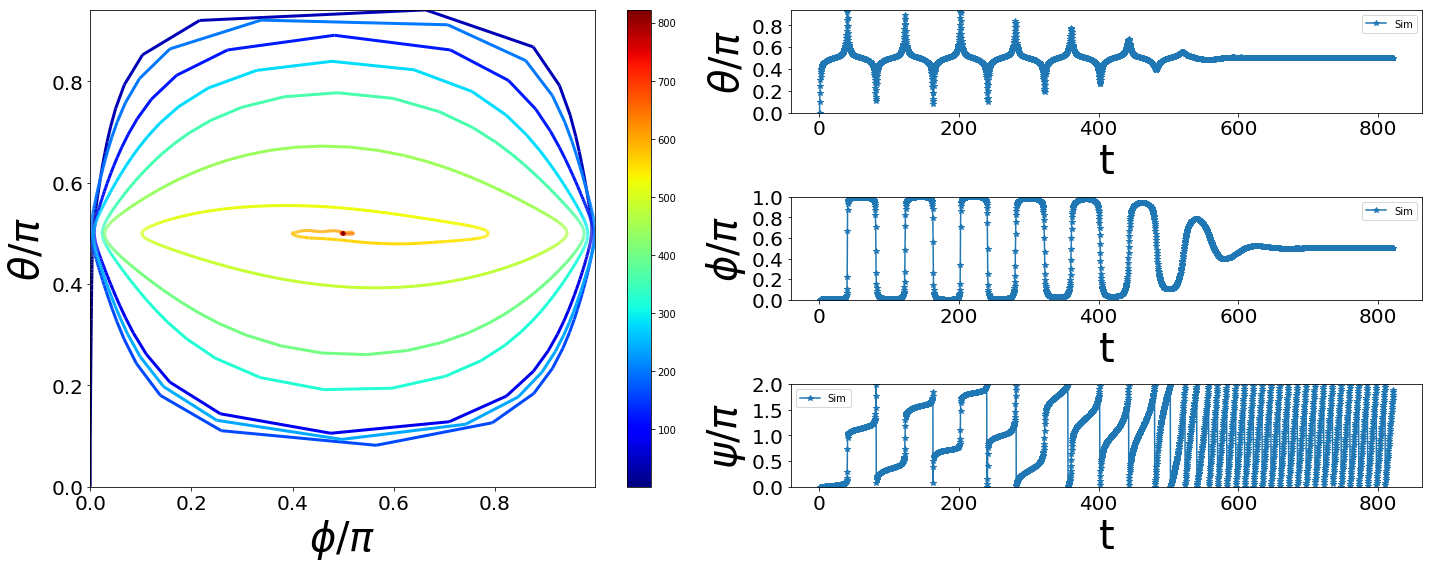

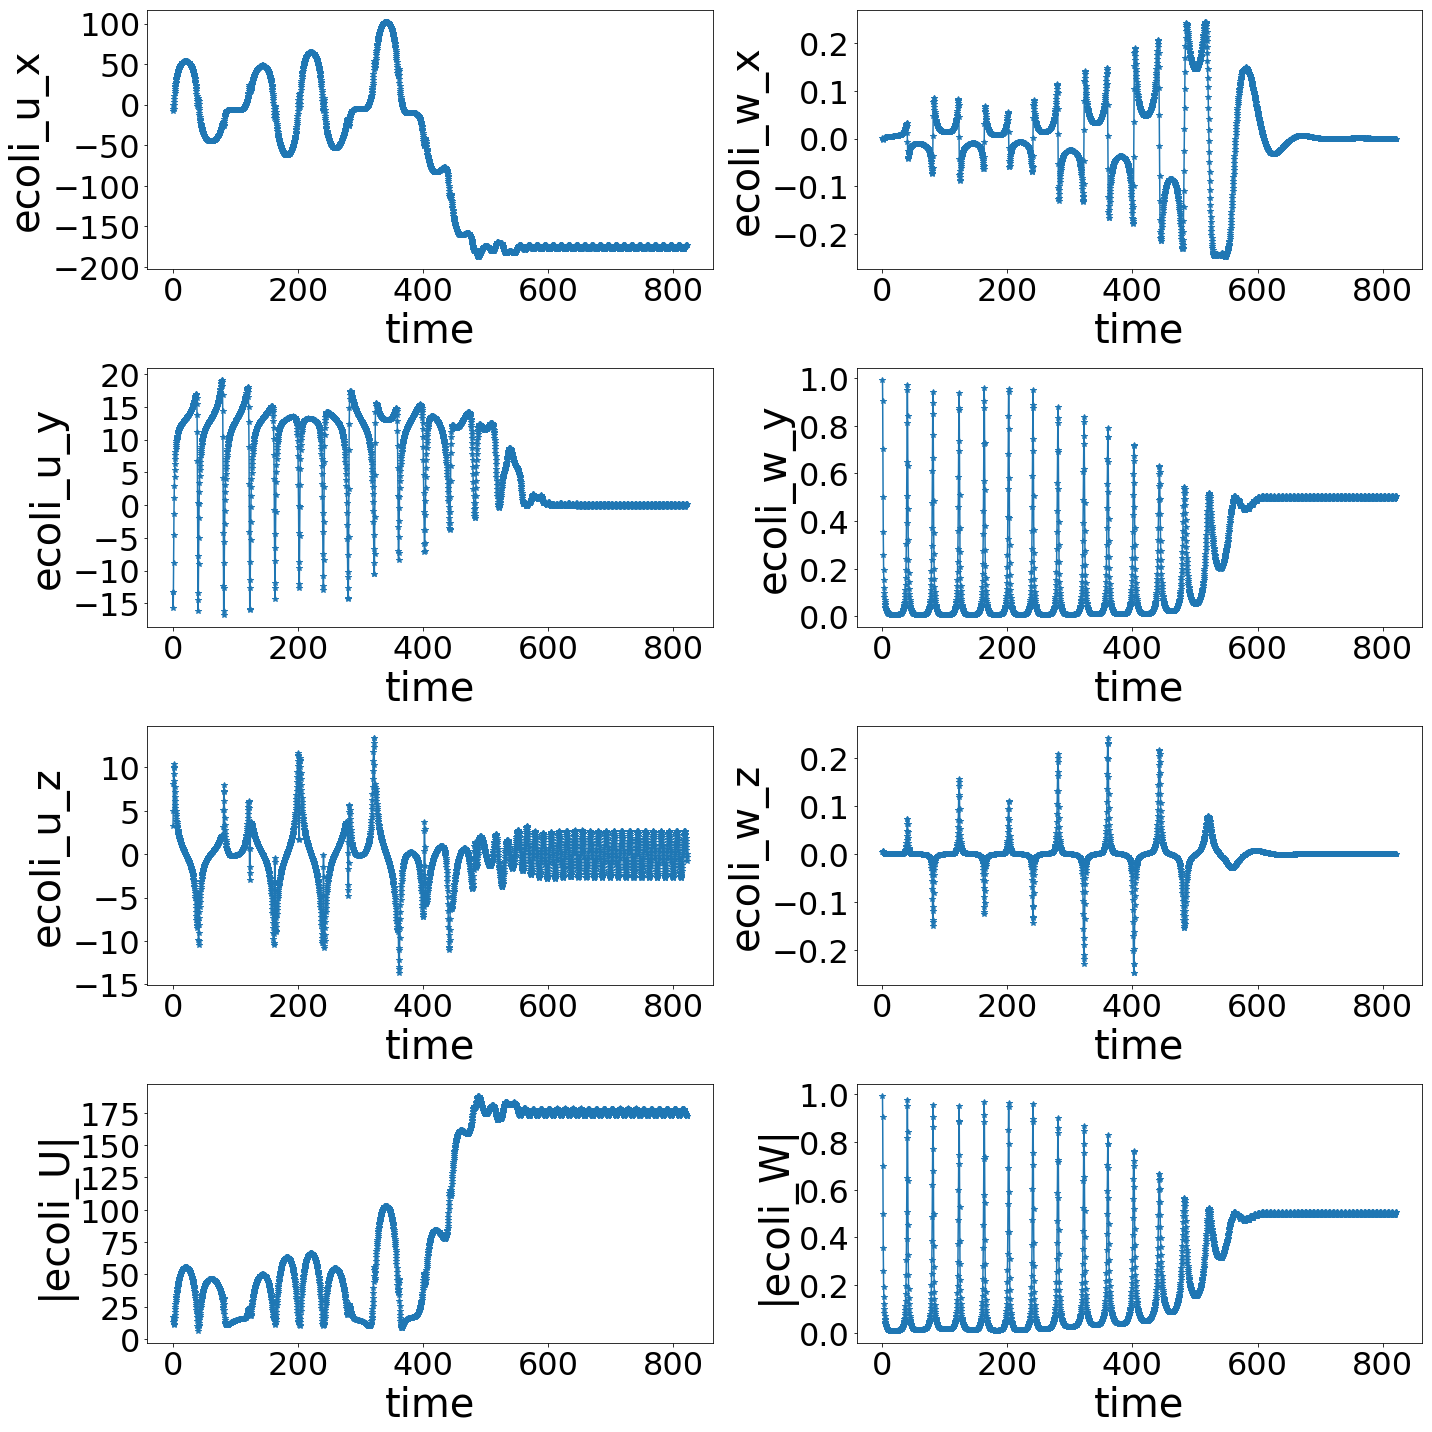

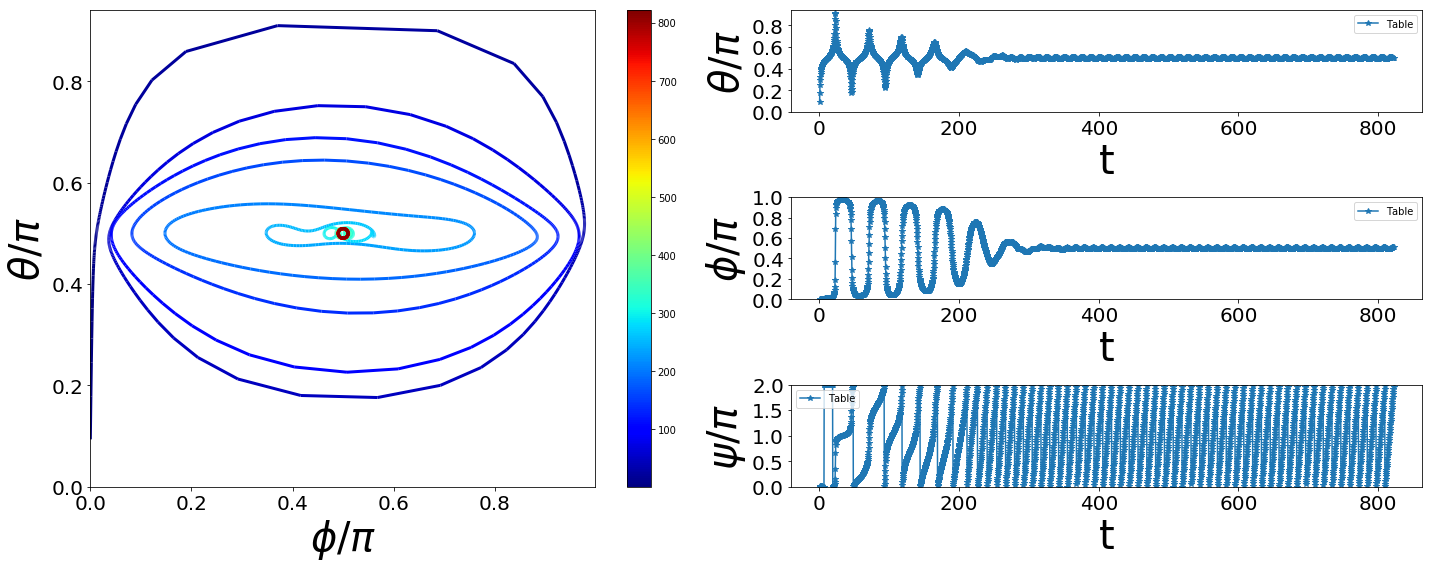

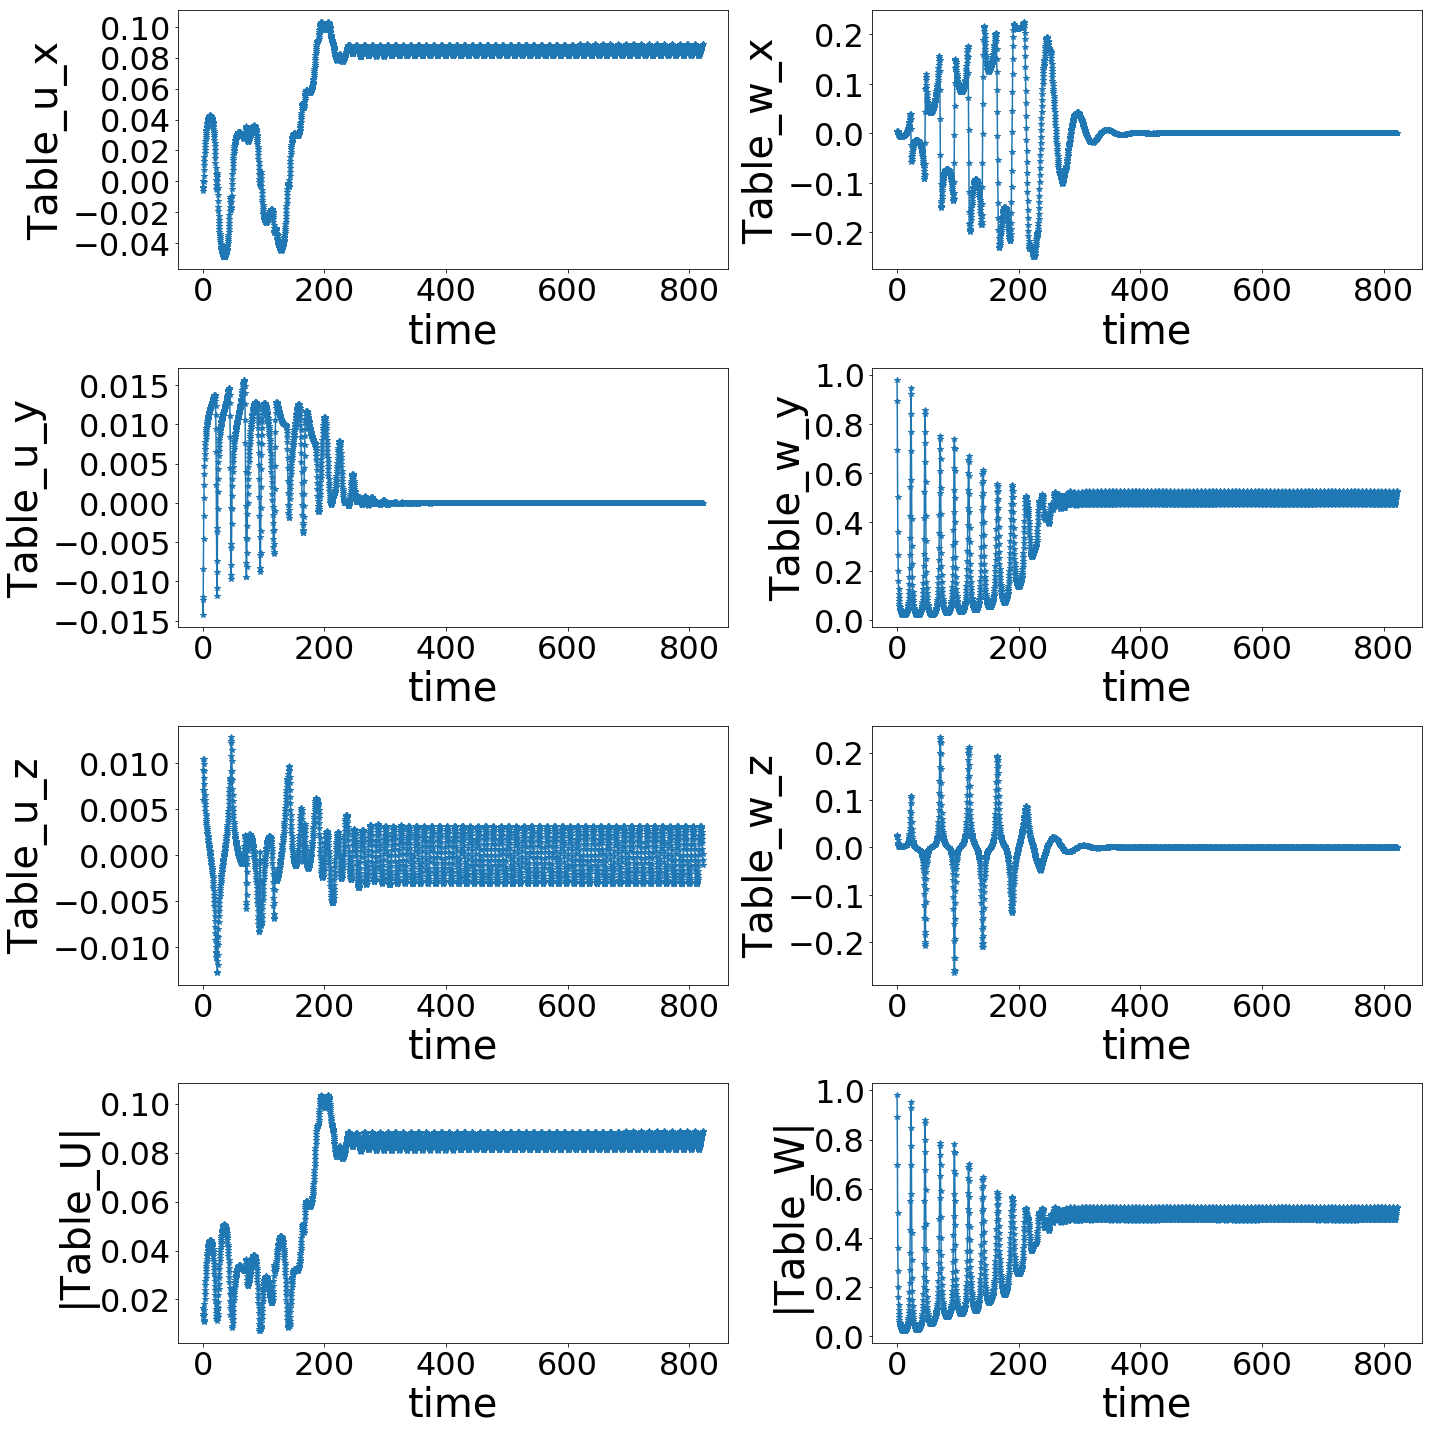

In [35]:
# compare simulation and table results. 
ini_idx = 0
plot_length = ecoli_U.shape[0] - ini_idx
# ini_idx = np.random.randint(0, ecoli_t.shape[0]-plot_length, 1)[0]

# calculate Table result
importlib.reload(jm)
planeShearRate = np.array((1, 0, 0))
tcenter = ecoli_center[ini_idx]
tnorm = ecoli_norm[ini_idx]
ini_psi = ecoli_psi[ini_idx]
tlateral_norm = ecoli_lateral_norm[ini_idx]
eval_dt = np.mean(np.diff(ecoli_t))
max_iter = plot_length
update_order = 1
helix_kwargs = {'name':         'helix',
                'center':       tcenter,
                'norm':         tnorm / np.linalg.norm(tnorm),
                'lateral_norm': tlateral_norm / np.linalg.norm(tlateral_norm),
                'speed':        0,
                'lbd':          np.nan, 
                'ini_psi':      ini_psi, 
                'table_name':   'hlxB01_tau1a', }
fileHandle = 'ShearTableProblem'
helix_obj = jm.TableObj(**helix_kwargs)
helix_obj.set_update_para(fix_x=False, fix_y=False, fix_z=False, update_order=update_order)
problem = jm.ShearTableProblem(name=fileHandle, planeShearRate=planeShearRate)
problem.add_obj(helix_obj)
t0 = time()
for idx in range(1, max_iter + 1):
    problem.update_location(eval_dt, print_handle='%d / %d' % (idx, max_iter))
t1 = time()
Table_X = np.vstack(helix_obj.center_hist)
Table_U = np.vstack(helix_obj.U_hist)
Table_P = np.vstack(helix_obj.norm_hist)
Table_P2 = np.vstack(helix_obj.lateral_norm_hist)
Table_t = np.arange(max_iter) * eval_dt + eval_dt
Table_theta, Table_phi, Table_psi = helix_obj.theta_phi_psi
print('%s: run %d loops using %f' % (fileHandle, max_iter, (t1 - t0)))

theta_lim = [np.min(np.hstack((ecoli_theta[ini_idx:ini_idx+plot_length], Table_theta))) / np.pi, 
             np.max(np.hstack((ecoli_theta[ini_idx:ini_idx+plot_length], Table_theta))) / np.pi]
phi_lim = [np.min(np.hstack((ecoli_phi[ini_idx:ini_idx+plot_length], Table_phi))) / np.pi, 
             np.max(np.hstack((ecoli_phi[ini_idx:ini_idx+plot_length], Table_phi))) / np.pi]
psi_lim = [np.min(np.hstack((ecoli_psi[ini_idx:ini_idx+plot_length], Table_psi))) / np.pi, 
             np.max(np.hstack((ecoli_psi[ini_idx:ini_idx+plot_length], Table_psi))) / np.pi]
########################################################################################

# show simulation results. 
fig = plt.figure(figsize=(20, 8))
fig.patch.set_facecolor('white')
ax0 = plt.subplot2grid((3, 2), (0, 0), rowspan=3)
ax1 = plt.subplot2grid((3, 2), (0, 1), )
ax2 = plt.subplot2grid((3, 2), (1, 1), )
ax3 = plt.subplot2grid((3, 2), (2, 1), )
norm=plt.Normalize(ecoli_t[ini_idx:ini_idx+plot_length].min(), ecoli_t[ini_idx:ini_idx+plot_length].max())
cmap=plt.get_cmap('jet')
ax0.plot(ecoli_phi[ini_idx:ini_idx+plot_length] / np.pi, ecoli_theta[ini_idx:ini_idx+plot_length] / np.pi, ' ')
# ax0.plot(ecoli_phi / np.pi, ecoli_theta / np.pi, '*', ms=fontsize*0.5)
lc = spf.colorline(ecoli_phi[ini_idx:ini_idx+plot_length] / np.pi, 
                   ecoli_theta[ini_idx:ini_idx+plot_length] / np.pi, 
                   ecoli_t[ini_idx:ini_idx+plot_length], 
                   ax=ax0, cmap=cmap, norm=norm, linewidth=3)
clb = fig.colorbar(lc, ax=ax0, orientation="vertical")
ax0.set_xlabel('$\\phi / \pi$', size=fontsize)
ax0.set_ylabel('$\\theta / \pi$', size=fontsize)
plt.sca(ax0)
plt.xticks(fontsize=fontsize*0.5)
plt.yticks(fontsize=fontsize*0.5)
# ax1.plot(Jeffery_t, Jeffery_theta / np.pi, label='Jeffery')
# ax2.plot(Jeffery_t, Jeffery_phi / np.pi, label='Jeffery')
ax1.plot(ecoli_t[ini_idx:ini_idx+plot_length], ecoli_theta[ini_idx:ini_idx+plot_length] / np.pi, '-*', label='Sim')
ax2.plot(ecoli_t[ini_idx:ini_idx+plot_length], ecoli_phi[ini_idx:ini_idx+plot_length] / np.pi, '-*', label='Sim')
ax3.plot(ecoli_t[ini_idx:ini_idx+plot_length], ecoli_psi[ini_idx:ini_idx+plot_length] / np.pi, '-*', label='Sim')
for axi, axyi in zip((ax1, ax2, ax3), ('$\\theta / \pi$', '$\\phi / \pi$', '$\\psi / \pi$')):
    plt.sca(axi)
    axi.set_xlabel('t', size=fontsize)
    axi.set_ylabel('%s' % axyi, size=fontsize)
    axi.legend()
    plt.xticks(fontsize=fontsize*0.5)
    plt.yticks(fontsize=fontsize*0.5)
plt.tight_layout()
ax0.set_xlim(phi_lim)
ax0.set_ylim(theta_lim)
ax1.set_ylim(theta_lim)
ax2.set_ylim(phi_lim)
ax3.set_ylim(psi_lim)
print('ini_idx', ini_idx)
print('ecoli_norm[ini_idx]', ecoli_norm[ini_idx])

# velocity of simulation results
fig, [(ax0, ax3), (ax1, ax4), (ax2, ax5), (ax6, ax7)] = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))
fig.patch.set_facecolor('white')
ax0.plot(ecoli_t[ini_idx:ini_idx+plot_length], ecoli_U[ini_idx:ini_idx+plot_length, 0], '-*')
ax1.plot(ecoli_t[ini_idx:ini_idx+plot_length], ecoli_U[ini_idx:ini_idx+plot_length, 1], '-*')
ax2.plot(ecoli_t[ini_idx:ini_idx+plot_length], ecoli_U[ini_idx:ini_idx+plot_length, 2], '-*')
ax3.plot(ecoli_t[ini_idx:ini_idx+plot_length], ecoli_U[ini_idx:ini_idx+plot_length, 3], '-*')
ax4.plot(ecoli_t[ini_idx:ini_idx+plot_length], ecoli_U[ini_idx:ini_idx+plot_length, 4], '-*')
ax5.plot(ecoli_t[ini_idx:ini_idx+plot_length], ecoli_U[ini_idx:ini_idx+plot_length, 5], '-*')
ax6.plot(ecoli_t[ini_idx:ini_idx+plot_length], np.linalg.norm(ecoli_U[ini_idx:ini_idx+plot_length, :3], axis=1), '-*')
ax7.plot(ecoli_t[ini_idx:ini_idx+plot_length], np.linalg.norm(ecoli_U[ini_idx:ini_idx+plot_length, 3:], axis=1), '-*')
for axi, axyi in zip((ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7),
                     ('ecoli_u_x', 'ecoli_u_y', 'ecoli_u_z', 
                      'ecoli_w_x', 'ecoli_w_y', 'ecoli_w_z', 
                      '|ecoli_U|', '|ecoli_W|')):
    plt.sca(axi)
    axi.set_xlabel('time', size=fontsize)
    axi.set_ylabel('%s' % axyi, size=fontsize)
    plt.xticks(fontsize=fontsize*0.8)
    plt.yticks(fontsize=fontsize*0.8)
plt.tight_layout()

###################################################################################
# show table results. 
fig = plt.figure(figsize=(20, 8))
fig.patch.set_facecolor('white')
ax0 = plt.subplot2grid((3, 2), (0, 0), rowspan=3)
ax1 = plt.subplot2grid((3, 2), (0, 1), )
ax2 = plt.subplot2grid((3, 2), (1, 1), )
ax3 = plt.subplot2grid((3, 2), (2, 1), )
norm=plt.Normalize(Table_t.min(), Table_t.max())
cmap=plt.get_cmap('jet')
ax0.plot(Table_phi / np.pi, Table_theta / np.pi, ' ')
lc = spf.colorline(Table_phi / np.pi, Table_theta / np.pi, Table_t, 
                   ax=ax0, cmap=cmap, norm=norm, linewidth=3)
clb = fig.colorbar(lc, ax=ax0, orientation="vertical")
ax0.set_xlabel('$\\phi / \pi$', size=fontsize)
ax0.set_ylabel('$\\theta / \pi$', size=fontsize)
plt.sca(ax0)
plt.xticks(fontsize=fontsize*0.5)
plt.yticks(fontsize=fontsize*0.5)
ax1.plot(Table_t, Table_theta / np.pi, '-*', label='Table')
ax2.plot(Table_t, Table_phi / np.pi, '-*', label='Table')
ax3.plot(Table_t, Table_psi / np.pi, '-*', label='Table')
for axi, axyi in zip((ax1, ax2, ax3), ('$\\theta / \pi$', '$\\phi / \pi$', '$\\psi / \pi$')):
    plt.sca(axi)
    axi.set_xlabel('t', size=fontsize)
    axi.set_ylabel('%s' % axyi, size=fontsize)
    axi.legend()
    plt.xticks(fontsize=fontsize*0.5)
    plt.yticks(fontsize=fontsize*0.5)
plt.tight_layout()
ax0.set_xlim(phi_lim)
ax0.set_ylim(theta_lim)
ax1.set_ylim(theta_lim)
ax2.set_ylim(phi_lim)
ax3.set_ylim(psi_lim)
print('ini_psi', ini_psi)

# velocity of table results
fig, [(ax0, ax3), (ax1, ax4), (ax2, ax5), (ax6, ax7)] = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))
fig.patch.set_facecolor('white')
ax0.plot(Table_t[:], Table_U[:, 0], '-*')
ax1.plot(Table_t[:], Table_U[:, 1], '-*')
ax2.plot(Table_t[:], Table_U[:, 2], '-*')
ax3.plot(Table_t[:], Table_U[:, 3], '-*')
ax4.plot(Table_t[:], Table_U[:, 4], '-*')
ax5.plot(Table_t[:], Table_U[:, 5], '-*')
ax6.plot(Table_t[:], np.linalg.norm(Table_U[:, :3], axis=1), '-*')
ax7.plot(Table_t[:], np.linalg.norm(Table_U[:, 3:], axis=1), '-*')
for axi, axyi in zip((ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7),
                     ('Table_u_x', 'Table_u_y', 'Table_u_z', 
                      'Table_w_x', 'Table_w_y', 'Table_w_z', 
                      '|Table_U|', '|Table_W|')):
    plt.sca(axi)
    axi.set_xlabel('time', size=fontsize)
    axi.set_ylabel('%s' % axyi, size=fontsize)
    plt.xticks(fontsize=fontsize*0.8)
    plt.yticks(fontsize=fontsize*0.8)
plt.tight_layout()

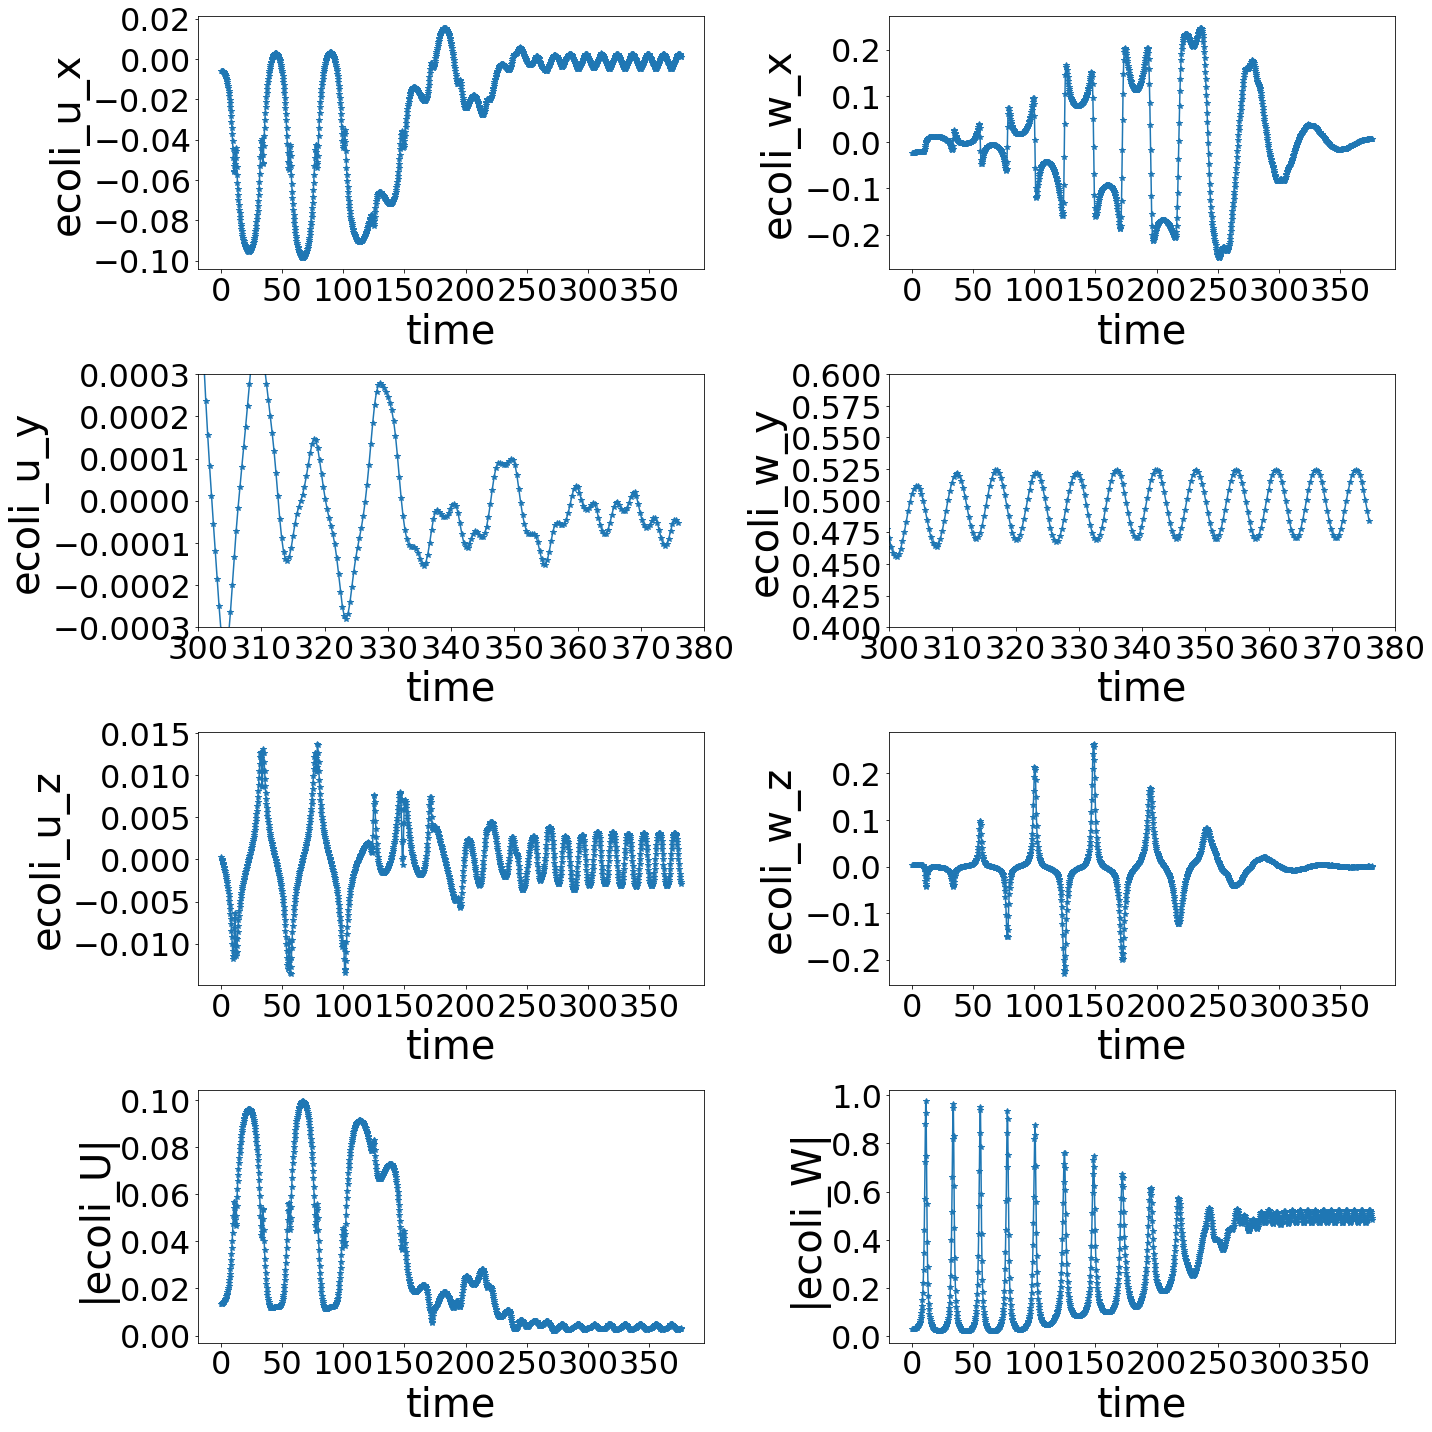

In [15]:
fig, [(ax0, ax3), (ax1, ax4), (ax2, ax5), (ax6, ax7)] = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))
fig.patch.set_facecolor('white')
ax0.plot(ecoli_t[idx], ecoli_U[idx, 0], '-*')
ax1.plot(ecoli_t[idx], ecoli_U[idx, 1], '-*')
ax2.plot(ecoli_t[idx], ecoli_U[idx, 2], '-*')
ax3.plot(ecoli_t[idx], ecoli_U[idx, 3], '-*')
ax4.plot(ecoli_t[idx], ecoli_U[idx, 4], '-*')
ax5.plot(ecoli_t[idx], ecoli_U[idx, 5], '-*')
ax6.plot(ecoli_t[idx], np.linalg.norm(ecoli_U[idx, :3], axis=1), '-*')
ax7.plot(ecoli_t[idx], np.linalg.norm(ecoli_U[idx, 3:], axis=1), '-*')
for axi, axyi in zip((ax0, ax1, ax2, ), ('x', 'y', 'z')):
    plt.sca(axi)
    axi.set_xlabel('time', size=fontsize)
    axi.set_ylabel('ecoli_u_%s' % axyi, size=fontsize)
#     axi.set_yscale('symlog', linthreshy=0.001, linscaley=10)
    plt.xticks(fontsize=fontsize*0.8)
    plt.yticks(fontsize=fontsize*0.8)
for axi, axyi in zip((ax3, ax4, ax5, ), ('x', 'y', 'z')):
    plt.sca(axi)
    axi.set_xlabel('time', size=fontsize)
    axi.set_ylabel('ecoli_w_%s' % axyi, size=fontsize)
    plt.xticks(fontsize=fontsize*0.8)
    plt.yticks(fontsize=fontsize*0.8)
for axi, axyi in zip((ax6, ax7), ('|ecoli_U|', '|ecoli_W|')):
    plt.sca(axi)
    axi.set_xlabel('time', size=fontsize)
    axi.set_ylabel(axyi, size=fontsize)
    plt.xticks(fontsize=fontsize*0.8)
    plt.yticks(fontsize=fontsize*0.8)

ax1.set_ylim(-3e-4, 3e-4)
ax1.set_xlim(300, 380)
ax4.set_xlim(300, 380)
ax4.set_ylim(0.4, 0.6)
plt.tight_layout()

/home/zhangji/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


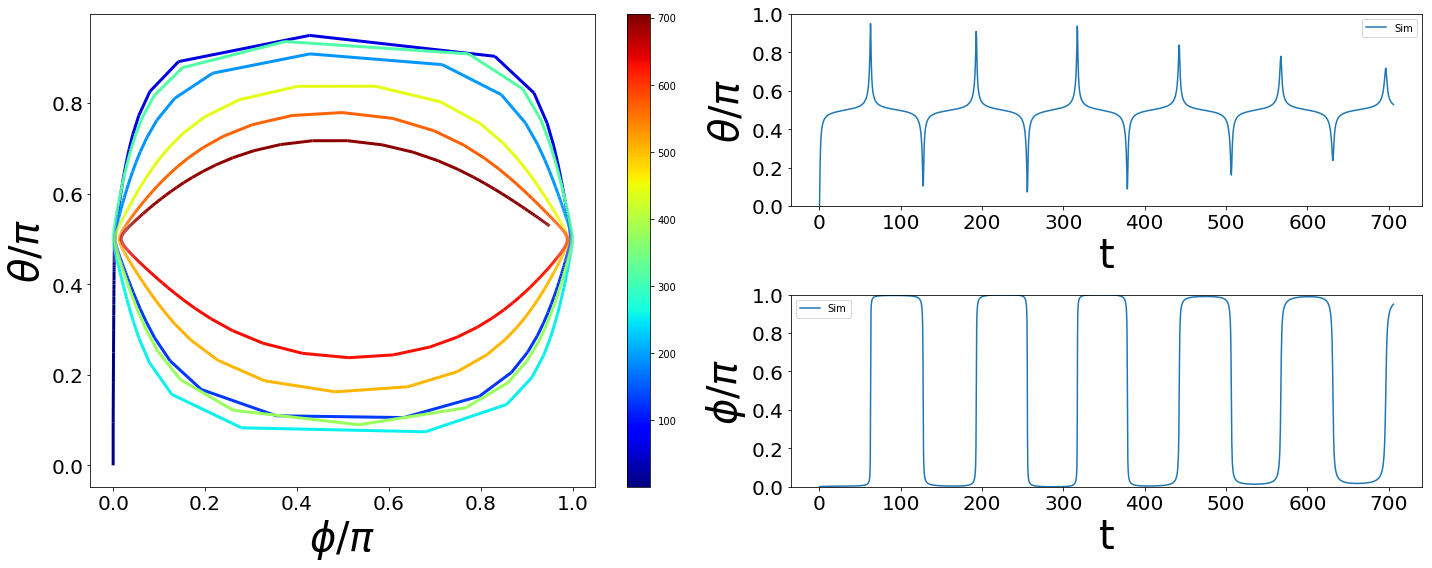

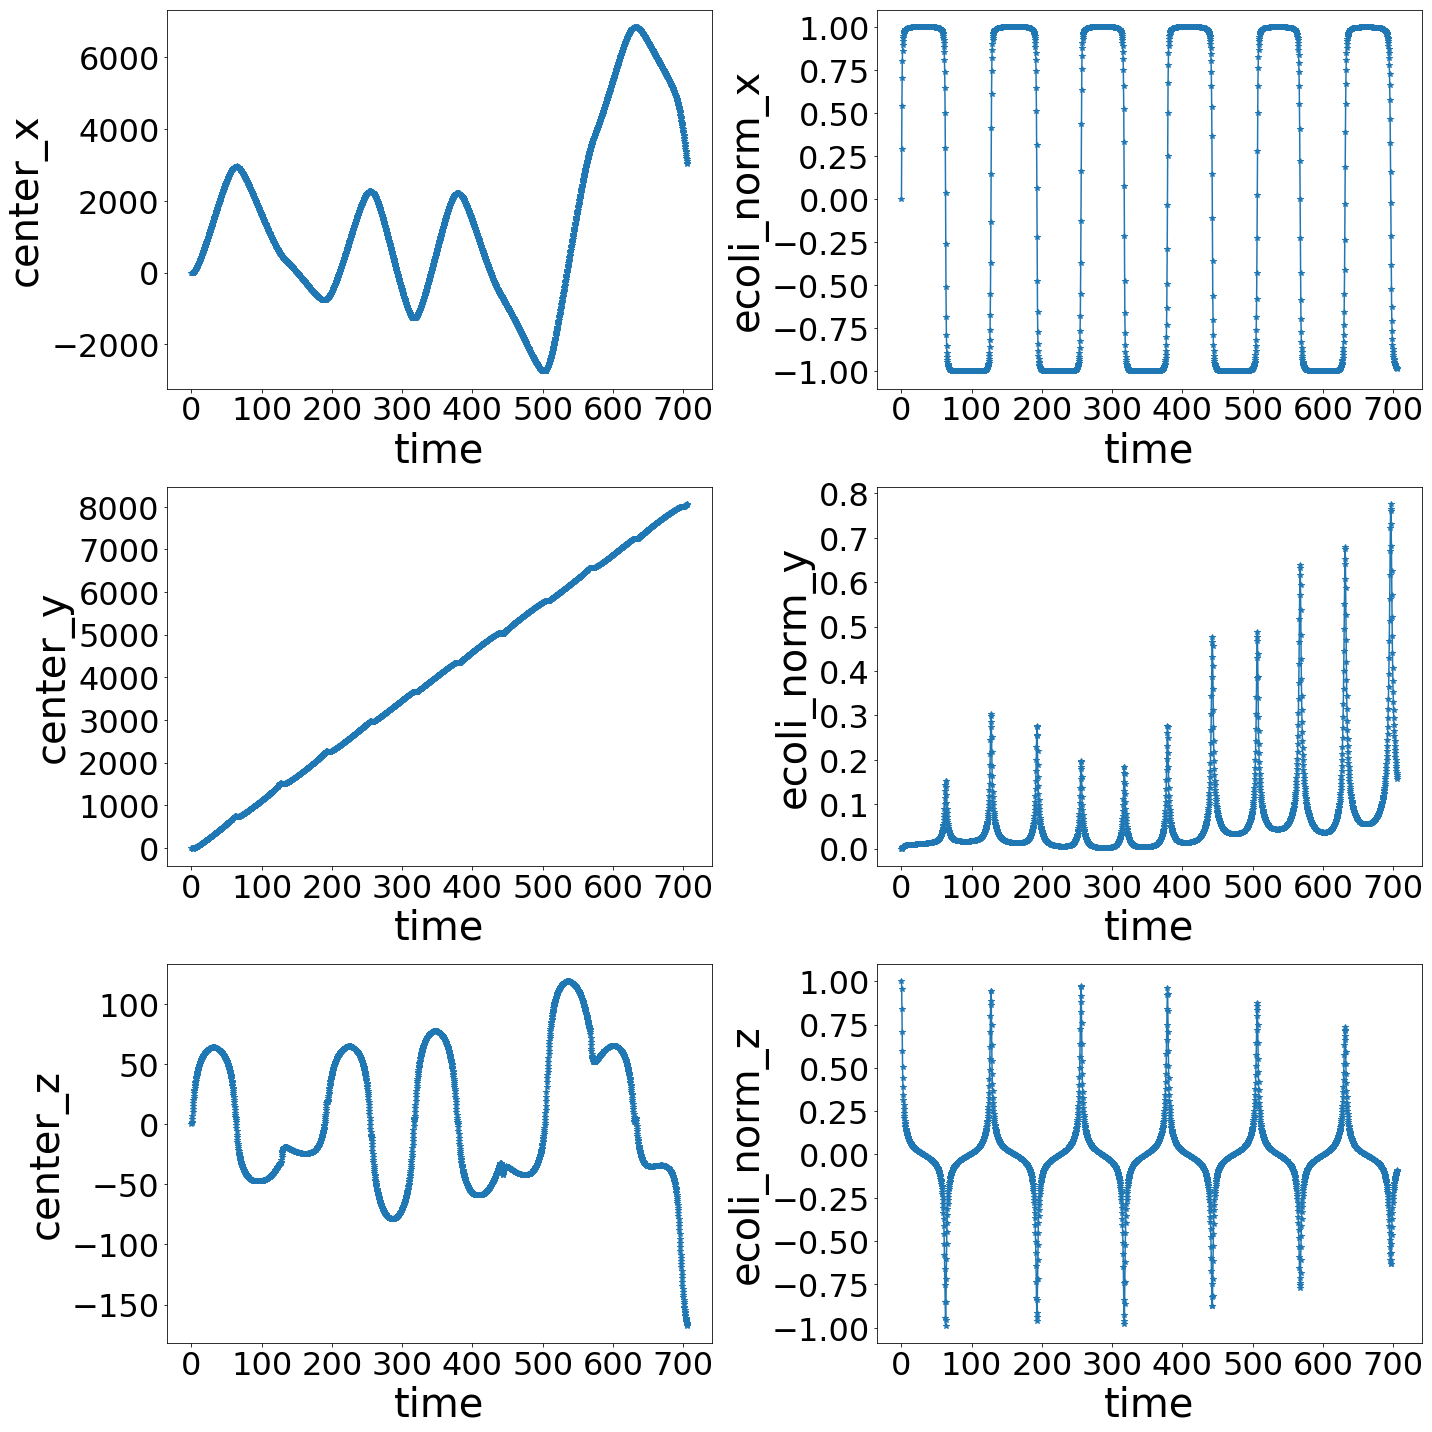

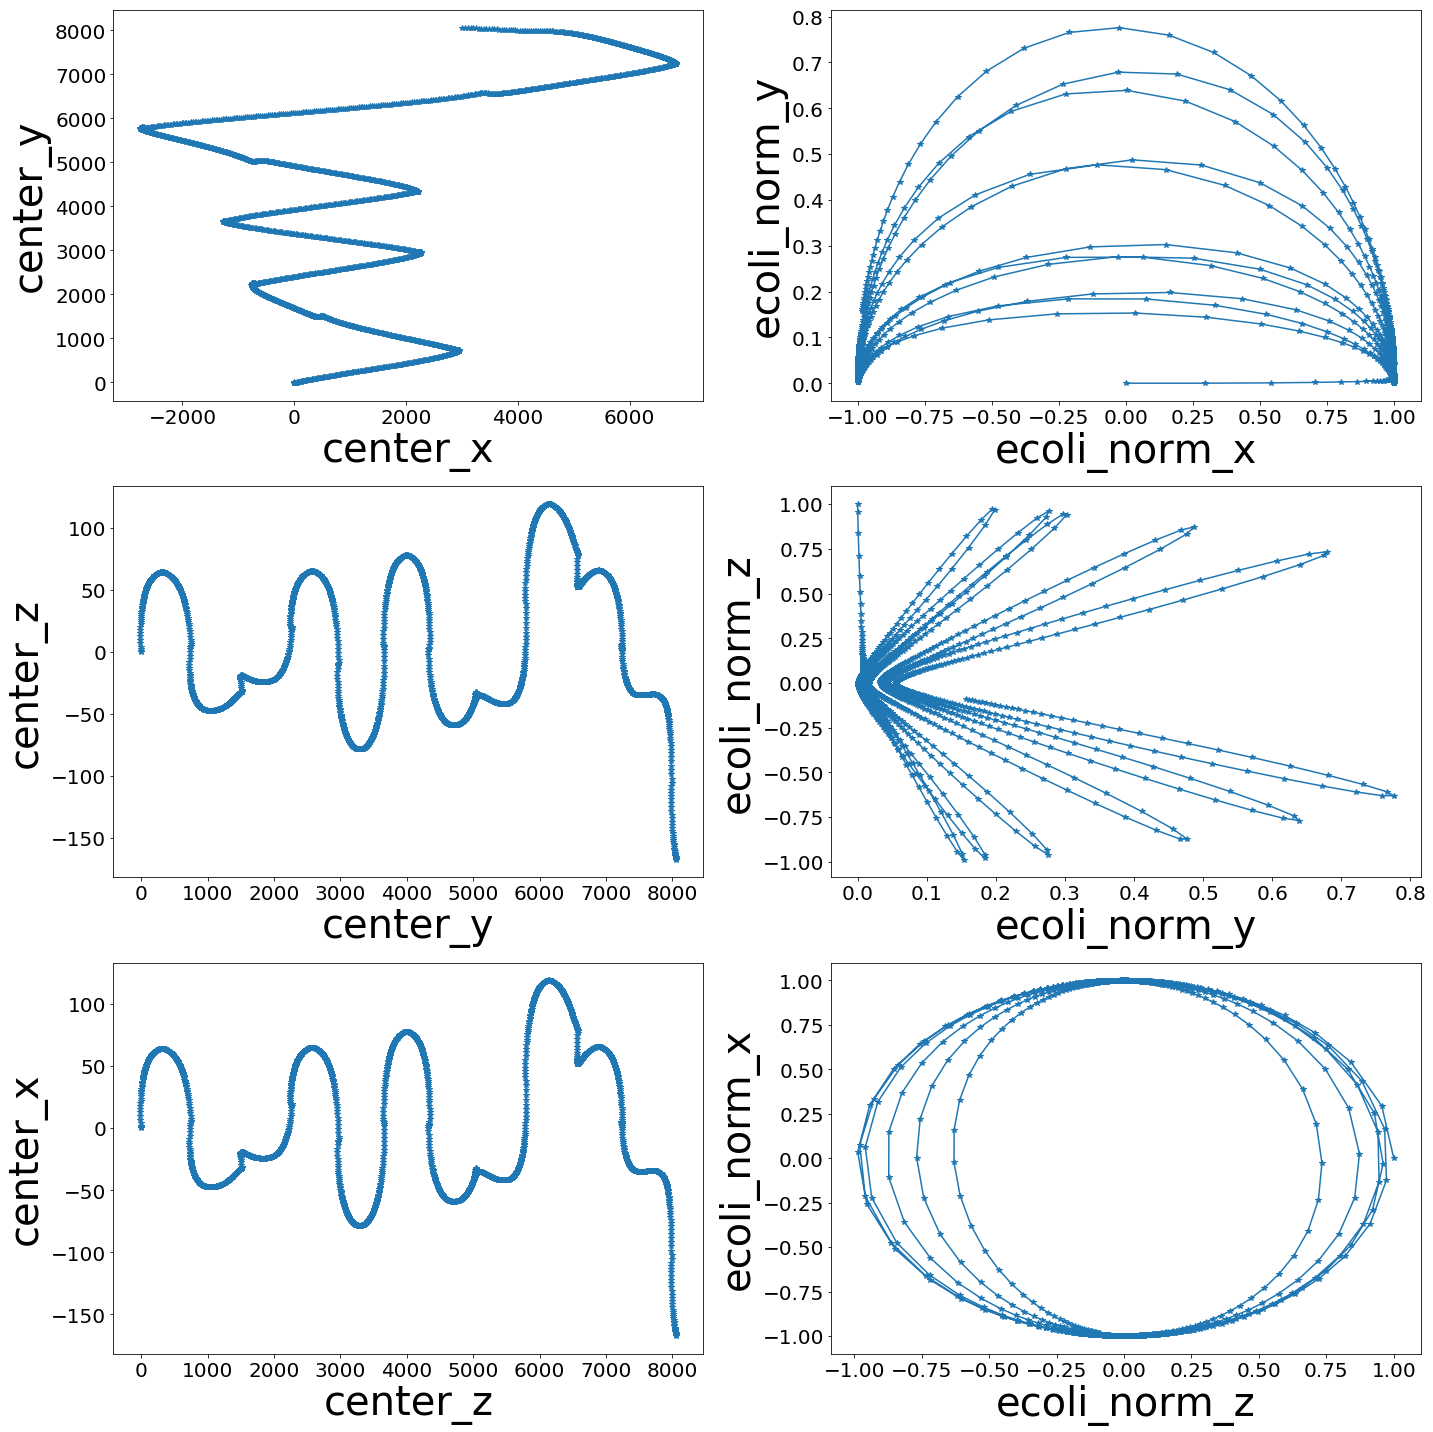

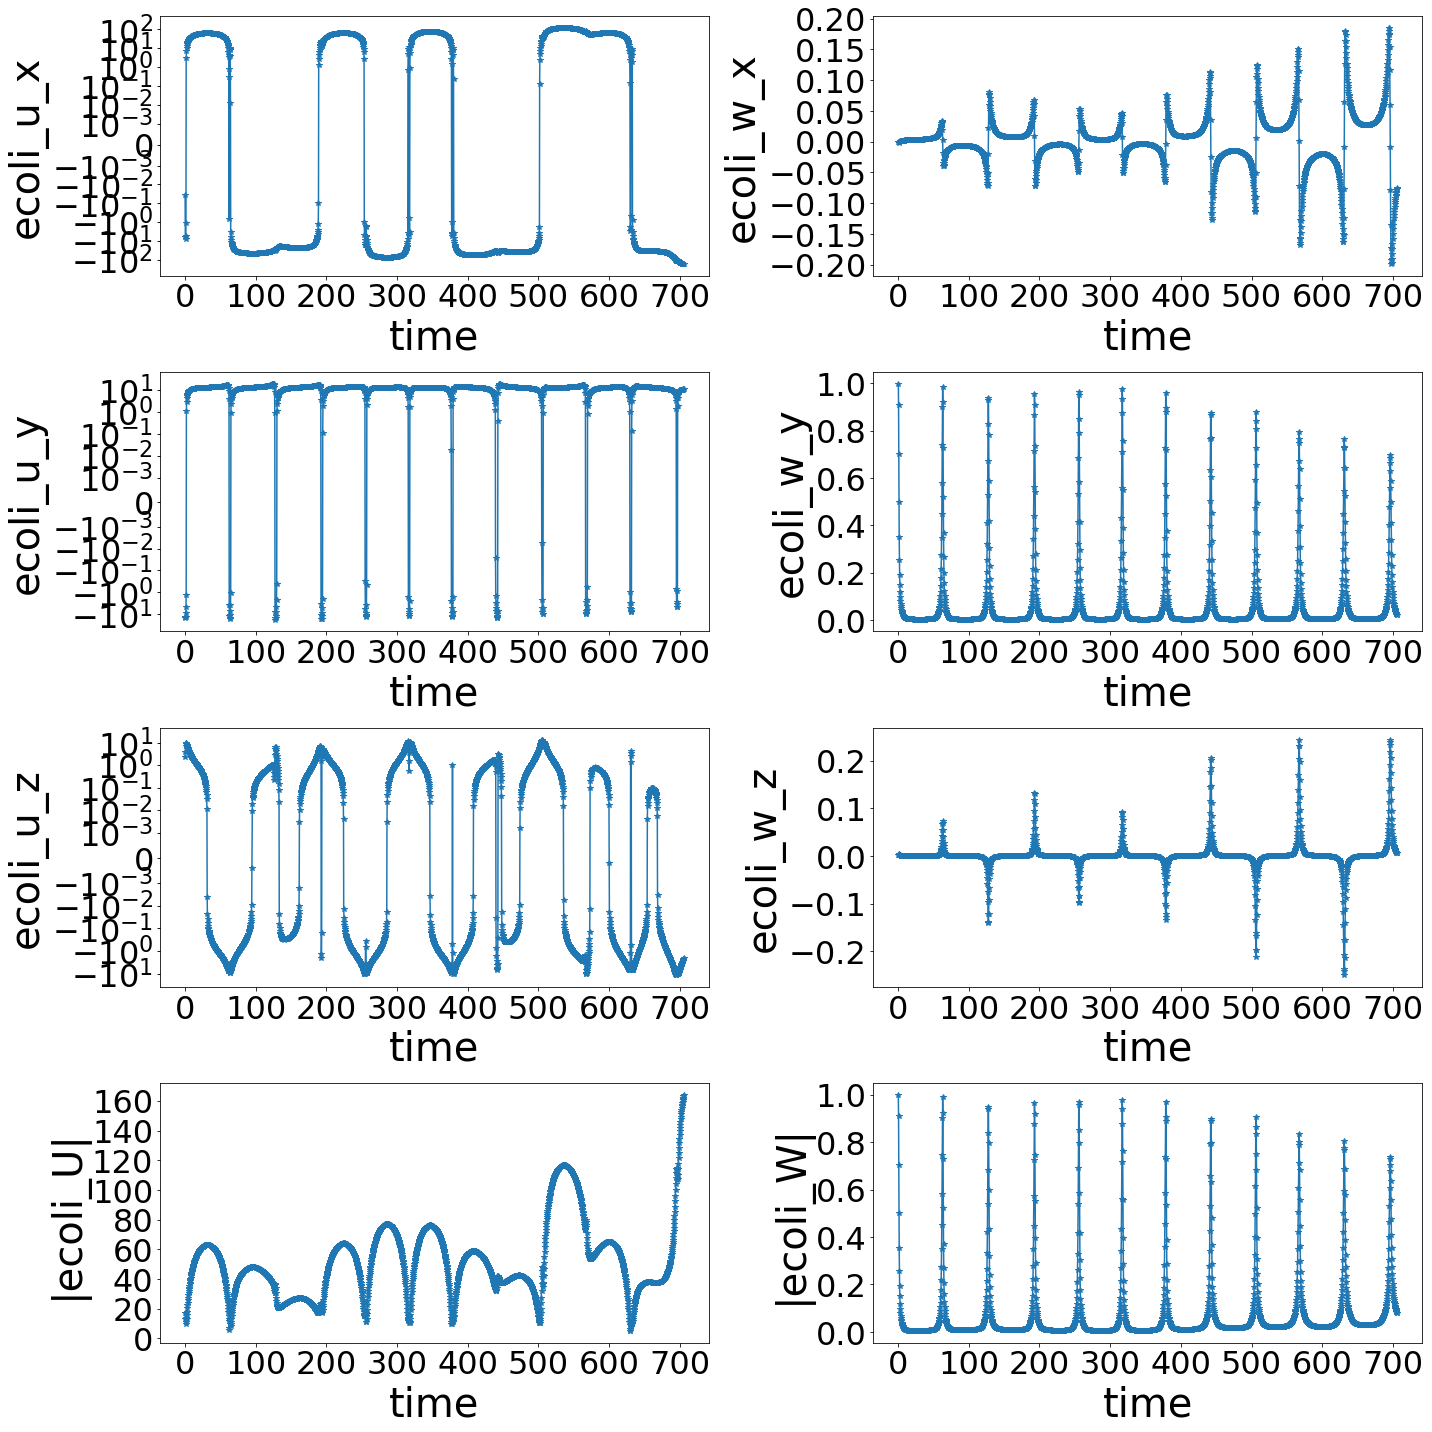

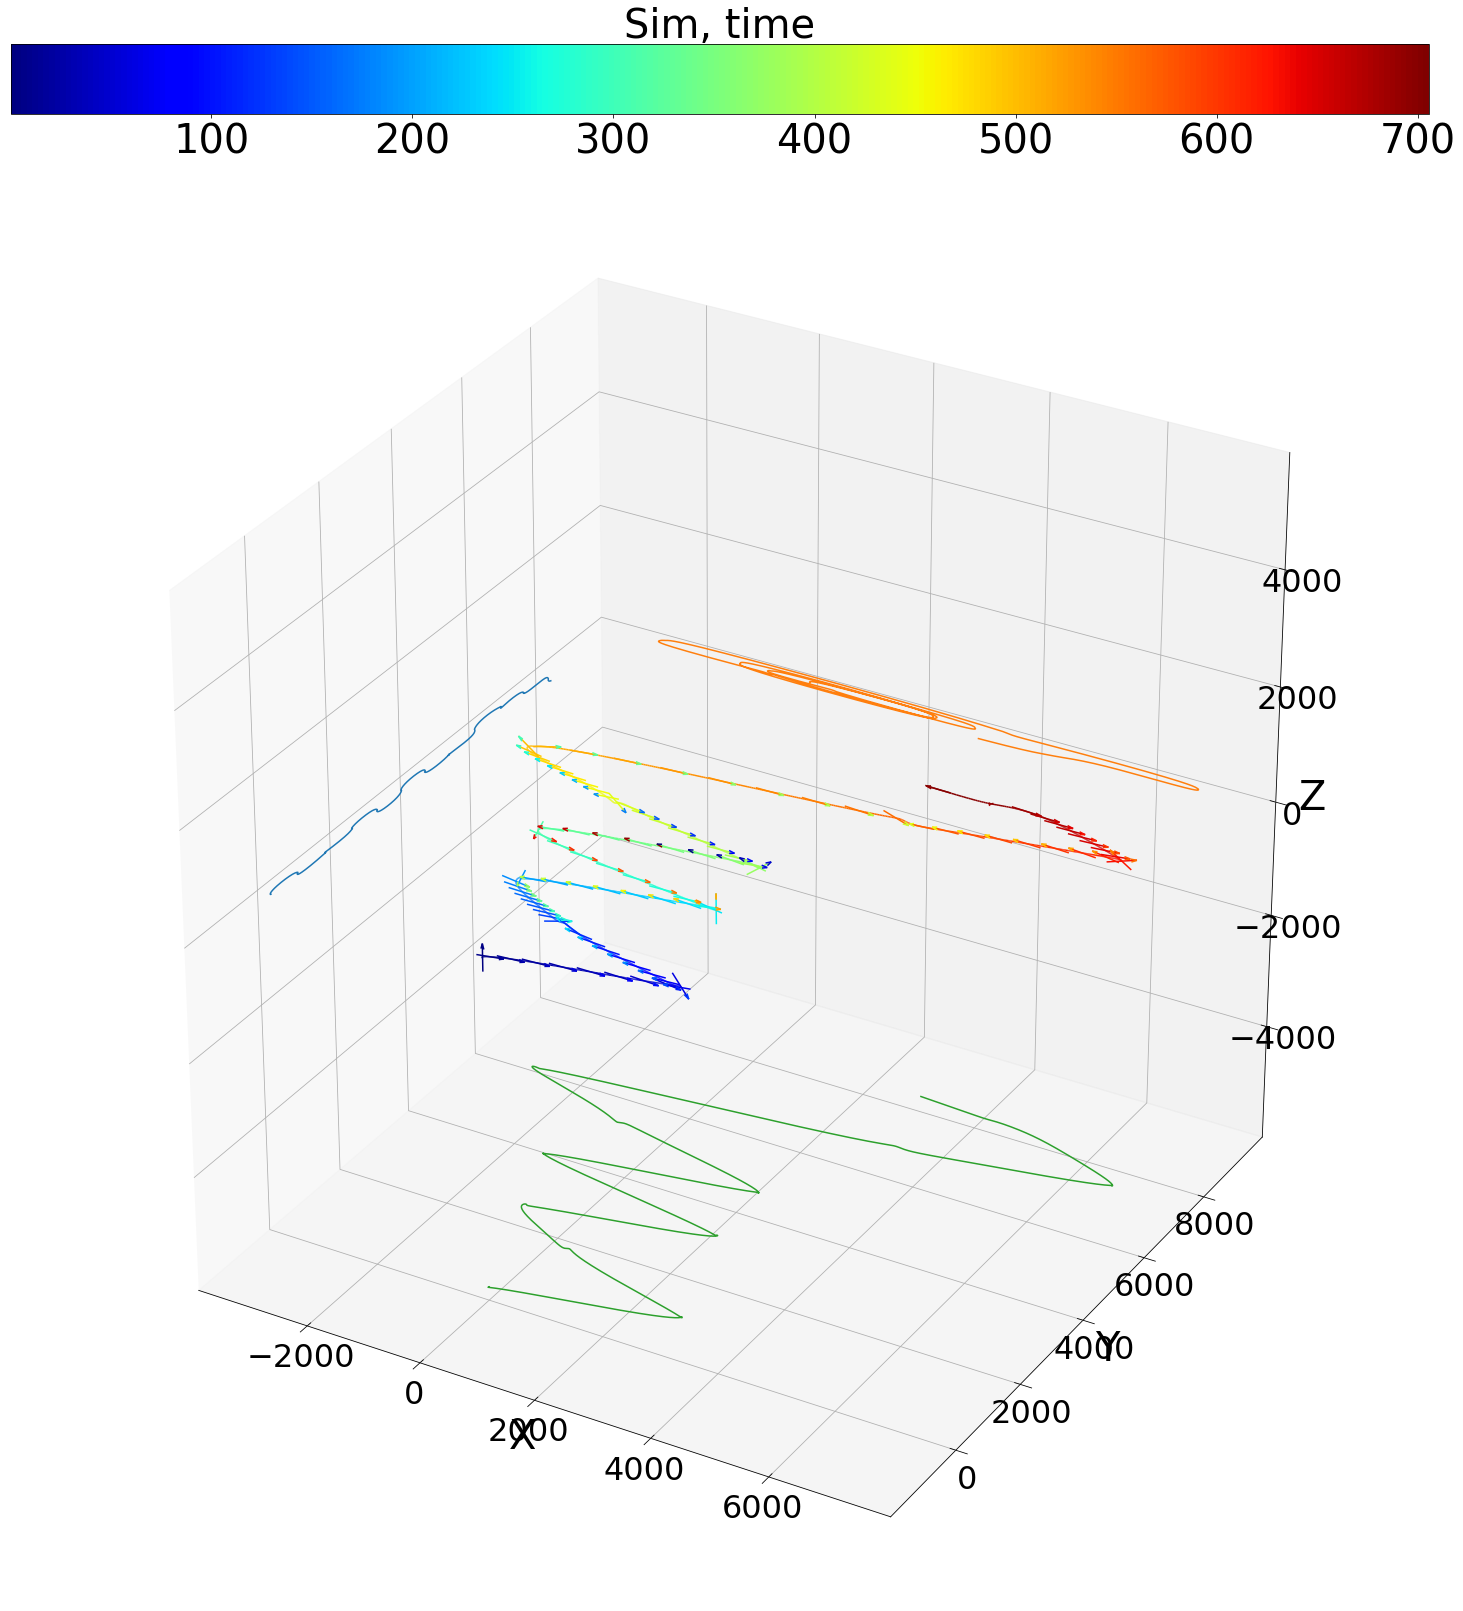

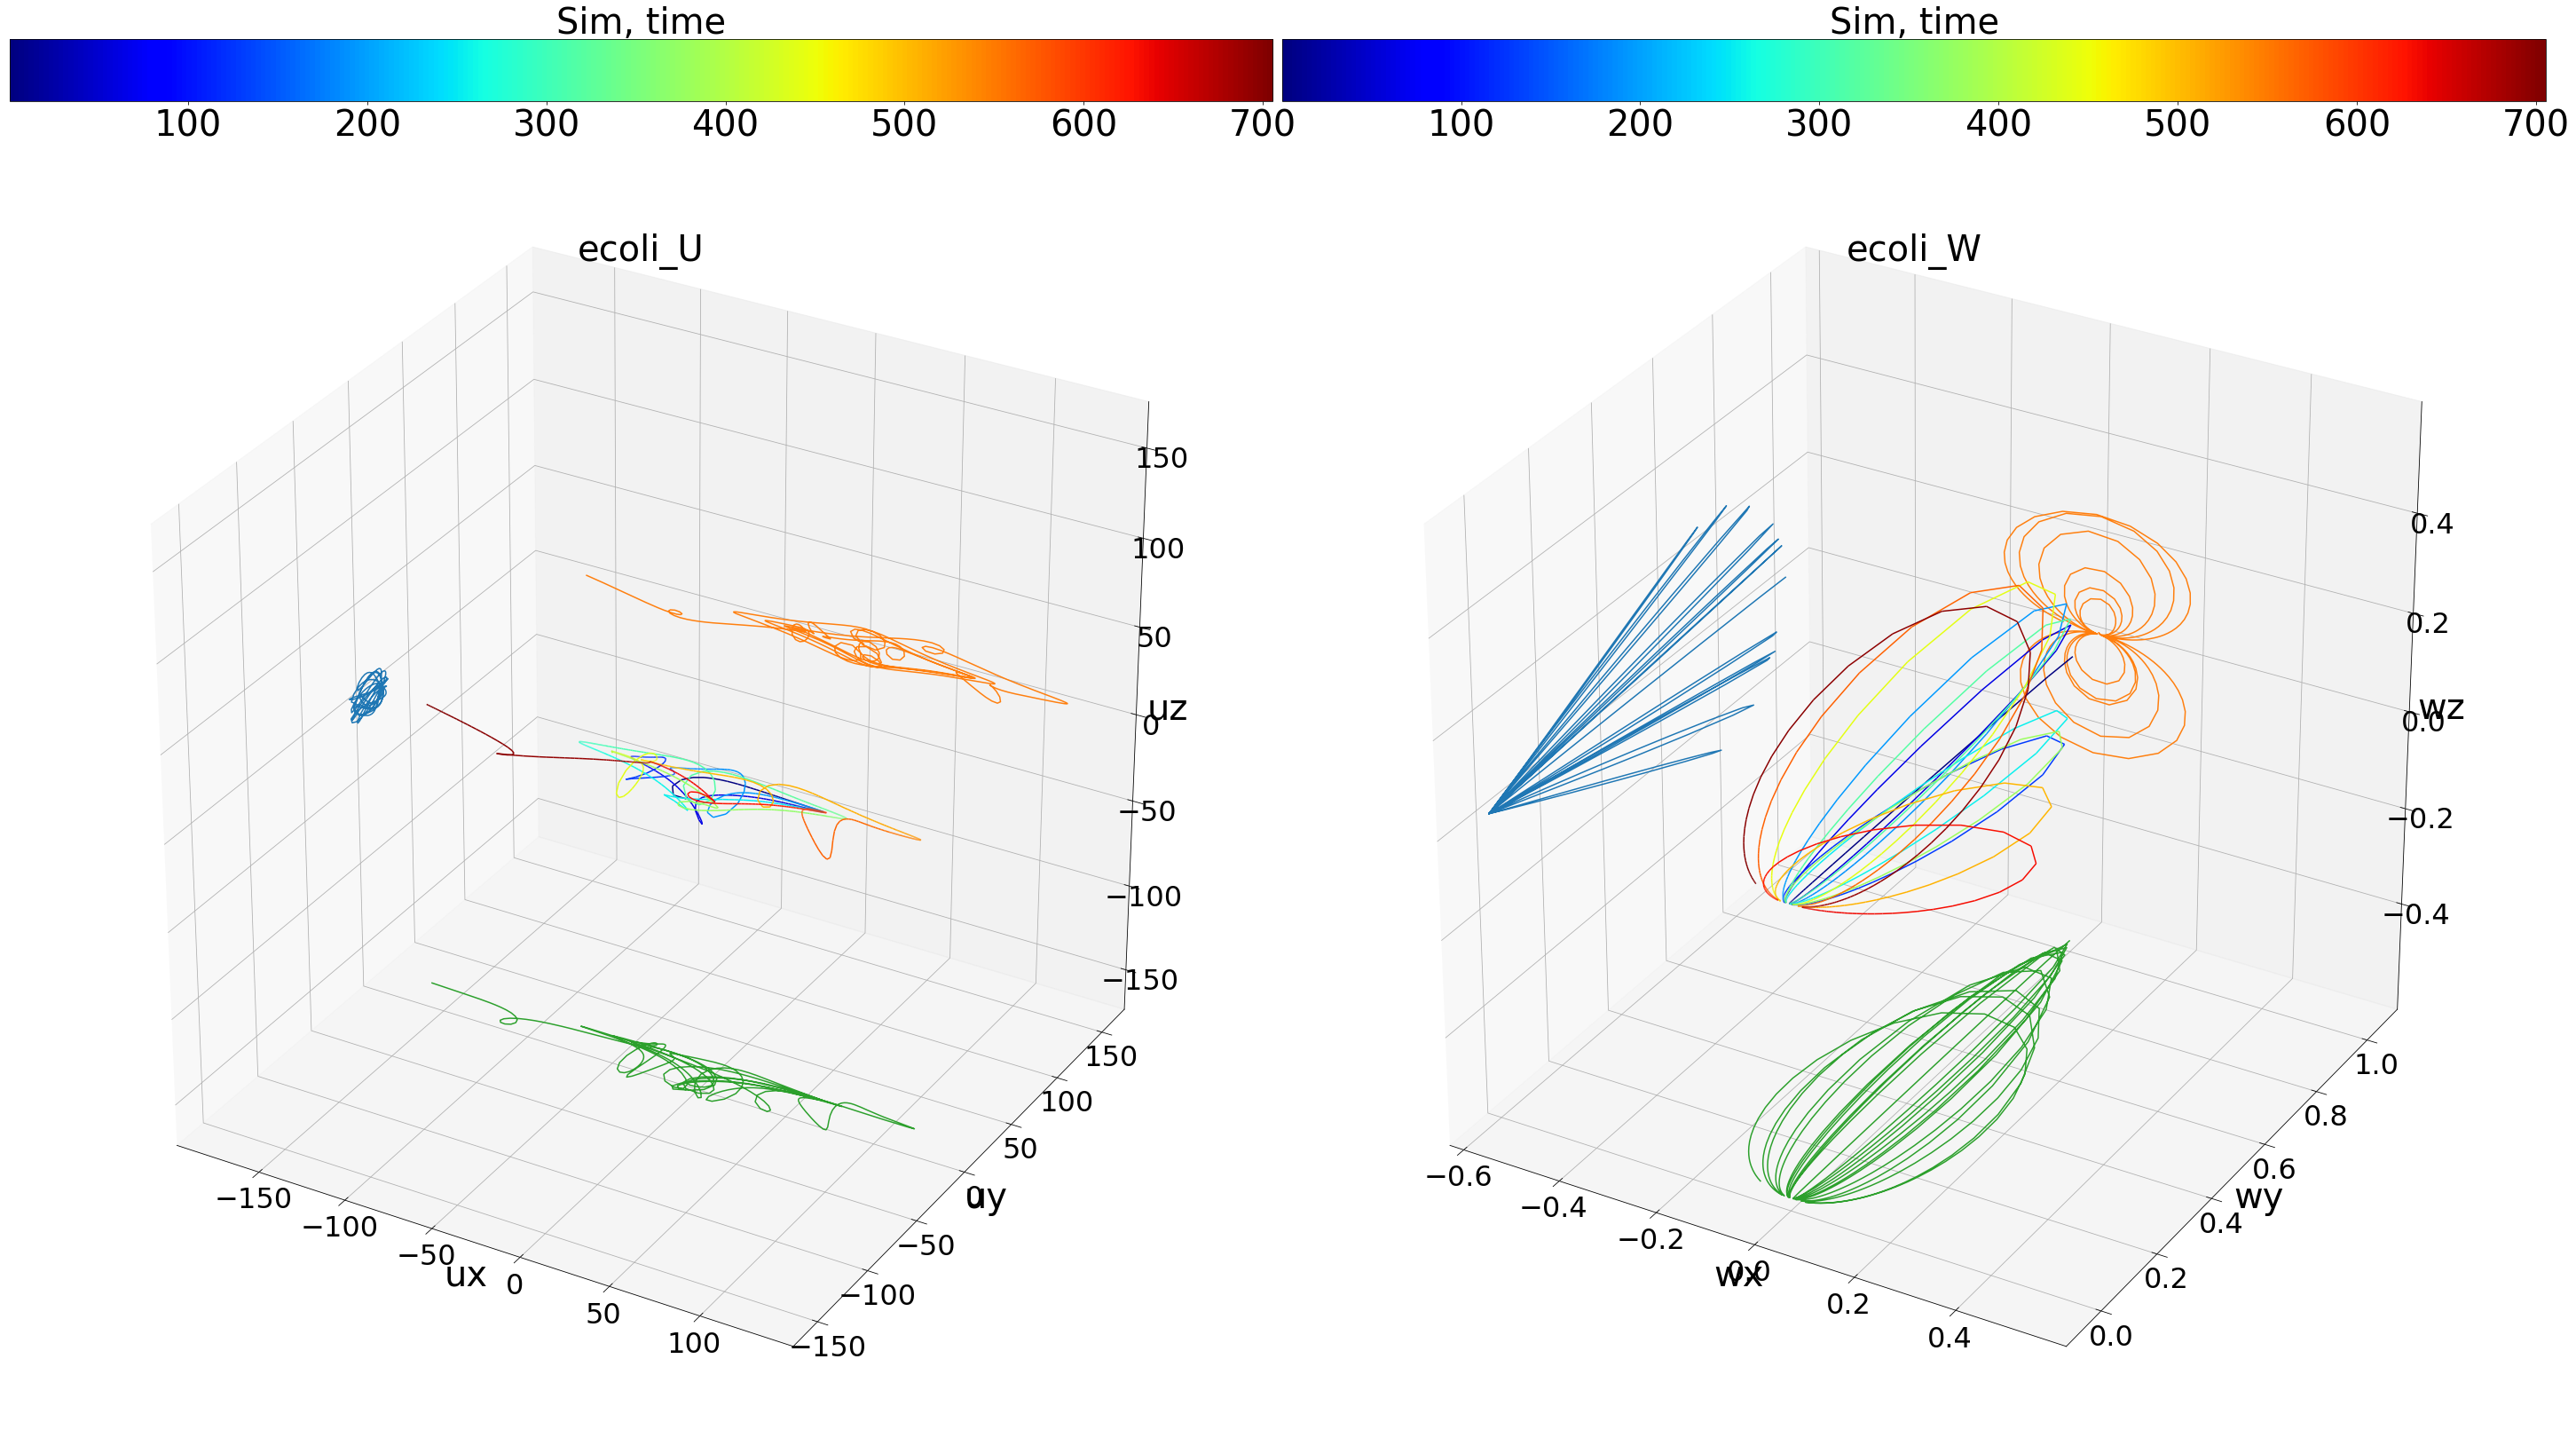

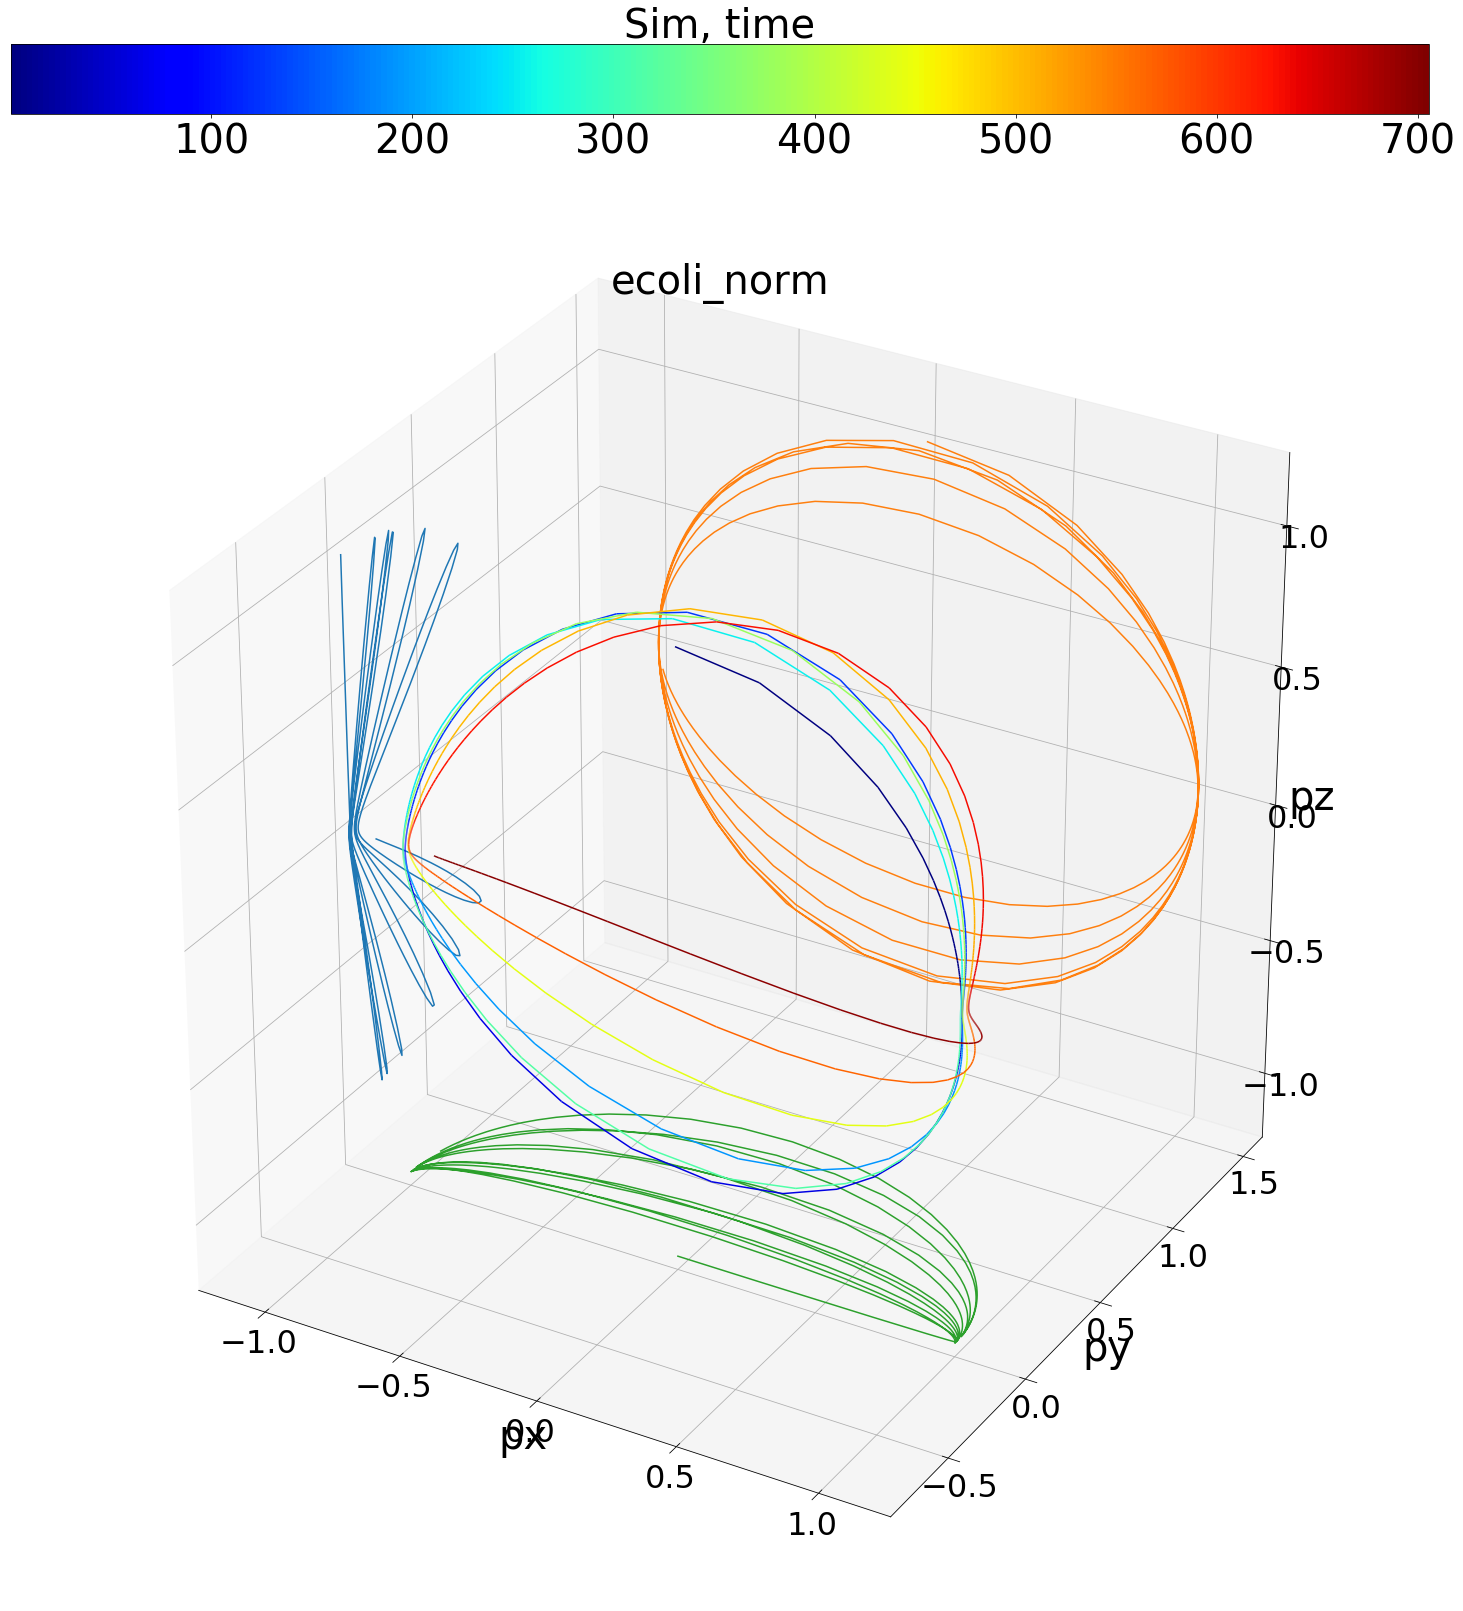

In [25]:
t_stp = ecoli_center.shape[0] // 100
idx = ecoli_t < np.inf

fig = plt.figure(figsize=(20, 8))
fig.patch.set_facecolor('white')
ax0 = plt.subplot2grid((2, 2), (0, 0), rowspan=2)
ax1 = plt.subplot2grid((2, 2), (0, 1), )
ax2 = plt.subplot2grid((2, 2), (1, 1), )
norm=plt.Normalize(ecoli_t.min(), ecoli_t.max())
cmap=plt.get_cmap('jet')
ax0.plot(ecoli_phi / np.pi, ecoli_theta / np.pi, ' ')
# ax0.plot(ecoli_phi / np.pi, ecoli_theta / np.pi, '*', ms=fontsize*0.5)
lc = spf.colorline(ecoli_phi / np.pi, ecoli_theta / np.pi, ecoli_t, 
                   ax=ax0, cmap=cmap, norm=norm, linewidth=3)
clb = fig.colorbar(lc, ax=ax0, orientation="vertical")
ax0.set_xlabel('$\\phi / \pi$', size=fontsize)
ax0.set_ylabel('$\\theta / \pi$', size=fontsize)
plt.sca(ax0)
plt.xticks(fontsize=fontsize*0.5)
plt.yticks(fontsize=fontsize*0.5)
# ax1.plot(Jeffery_t, Jeffery_theta / np.pi, label='Jeffery')
# ax2.plot(Jeffery_t, Jeffery_phi / np.pi, label='Jeffery')
ax1.plot(ecoli_t, ecoli_theta / np.pi, label='Sim')
ax2.plot(ecoli_t, ecoli_phi / np.pi, label='Sim')
for axi, axyi in zip((ax1, ax2, ), ('$\\theta / \pi$', '$\\phi / \pi$')):
    plt.sca(axi)
    axi.set_xlabel('t', size=fontsize)
    axi.set_ylabel('%s' % axyi, size=fontsize)
    axi.set_ylim((0, 1))
    axi.legend()
    plt.xticks(fontsize=fontsize*0.5)
    plt.yticks(fontsize=fontsize*0.5)
plt.tight_layout()

fig, [(ax0, ax3), (ax1, ax4), (ax2, ax5)] = plt.subplots(nrows=3, ncols=2, figsize=(20, 20))
fig.patch.set_facecolor('white')
ax0.plot(ecoli_t[idx], ecoli_center[idx, 0], '-*')
ax1.plot(ecoli_t[idx], ecoli_center[idx, 1], '-*')
ax2.plot(ecoli_t[idx], ecoli_center[idx, 2], '-*')
for axi, axyi in zip((ax0, ax1, ax2, ), ('x', 'y', 'z')):
    plt.sca(axi)
    axi.set_xlabel('time', size=fontsize)
    axi.set_ylabel('center_%s' % axyi, size=fontsize)
    plt.xticks(fontsize=fontsize*0.8)
    plt.yticks(fontsize=fontsize*0.8)
plt.tight_layout()
ax3.plot(ecoli_t[idx], ecoli_norm[idx, 0], '-*')
ax4.plot(ecoli_t[idx], ecoli_norm[idx, 1], '-*')
ax5.plot(ecoli_t[idx], ecoli_norm[idx, 2], '-*')
for axi, axyi in zip((ax3, ax4, ax5, ), ('x', 'y', 'z')):
    plt.sca(axi)
    axi.set_xlabel('time', size=fontsize)
    axi.set_ylabel('ecoli_norm_%s' % axyi, size=fontsize)
    plt.xticks(fontsize=fontsize*0.8)
    plt.yticks(fontsize=fontsize*0.8)
plt.tight_layout()

fig, [(ax0, ax3), (ax1, ax4), (ax2, ax5)] = plt.subplots(nrows=3, ncols=2, figsize=(20, 20))
fig.patch.set_facecolor('white')
ax0.plot(ecoli_center[:, 0], ecoli_center[:, 1], '-*')
ax1.plot(ecoli_center[:, 1], ecoli_center[:, 2], '-*')
ax2.plot(ecoli_center[:, 1], ecoli_center[:, 2], '-*')
for axi, axi_lbx, axi_lby in zip((ax0, ax1, ax2, ), ('x', 'y', 'z'), ('y', 'z', 'x')):
    plt.sca(axi)
    axi.set_xlabel('center_%s' % axi_lbx, size=fontsize)
    axi.set_ylabel('center_%s' % axi_lby, size=fontsize)
    plt.xticks(fontsize=fontsize*0.5)
    plt.yticks(fontsize=fontsize*0.5)
plt.tight_layout()
ax3.plot(ecoli_norm[idx, 0], ecoli_norm[idx, 1], '-*')
ax4.plot(ecoli_norm[idx, 1], ecoli_norm[idx, 2], '-*')
ax5.plot(ecoli_norm[idx, 2], ecoli_norm[idx, 0], '-*')
for axi, axi_lbx, axi_lby in zip((ax3, ax4, ax5, ), ('x', 'y', 'z'), ('y', 'z', 'x')):
    plt.sca(axi)
    axi.set_xlabel('ecoli_norm_%s' % axi_lbx, size=fontsize)
    axi.set_ylabel('ecoli_norm_%s' % axi_lby, size=fontsize)
    plt.xticks(fontsize=fontsize*0.5)
    plt.yticks(fontsize=fontsize*0.5)
plt.tight_layout()

fig, [(ax0, ax3), (ax1, ax4), (ax2, ax5), (ax6, ax7)] = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))
fig.patch.set_facecolor('white')
ax0.plot(ecoli_t[idx], ecoli_U[idx, 0], '-*')
ax1.plot(ecoli_t[idx], ecoli_U[idx, 1], '-*')
ax2.plot(ecoli_t[idx], ecoli_U[idx, 2], '-*')
ax3.plot(ecoli_t[idx], ecoli_U[idx, 3], '-*')
ax4.plot(ecoli_t[idx], ecoli_U[idx, 4], '-*')
ax5.plot(ecoli_t[idx], ecoli_U[idx, 5], '-*')
ax6.plot(ecoli_t[idx], np.linalg.norm(ecoli_U[idx, :3], axis=1), '-*')
ax7.plot(ecoli_t[idx], np.linalg.norm(ecoli_U[idx, 3:], axis=1), '-*')
for axi, axyi in zip((ax0, ax1, ax2, ), ('x', 'y', 'z')):
    plt.sca(axi)
    axi.set_xlabel('time', size=fontsize)
    axi.set_ylabel('ecoli_u_%s' % axyi, size=fontsize)
    axi.set_yscale('symlog', linthreshy=0.001, )
    plt.xticks(fontsize=fontsize*0.8)
    plt.yticks(fontsize=fontsize*0.8)
for axi, axyi in zip((ax3, ax4, ax5, ), ('x', 'y', 'z')):
    plt.sca(axi)
    axi.set_xlabel('time', size=fontsize)
    axi.set_ylabel('ecoli_w_%s' % axyi, size=fontsize)
    plt.xticks(fontsize=fontsize*0.8)
    plt.yticks(fontsize=fontsize*0.8)
for axi, axyi in zip((ax6, ax7), ('|ecoli_U|', '|ecoli_W|')):
    plt.sca(axi)
    axi.set_xlabel('time', size=fontsize)
    axi.set_ylabel(axyi, size=fontsize)
    plt.xticks(fontsize=fontsize*0.8)
    plt.yticks(fontsize=fontsize*0.8)
plt.tight_layout()

fig = plt.figure(figsize=(20, 20))
fig.patch.set_facecolor('white')
ax0 = fig.add_subplot(1, 1, 1, projection='3d')
cax1 = inset_axes(ax0, width="100%", height="5%", bbox_to_anchor=(0, 0.1, 1, 1),
               loc=1, bbox_transform=ax0.transAxes, borderpad=0,)
norm=plt.Normalize(ecoli_t.min(), ecoli_t.max())
cmap=plt.get_cmap('jet')
# Create the 3D-line collection object
points = ecoli_center.reshape(-1, 1, 3)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc = Line3DCollection(segments, cmap=cmap, norm=norm)
lc.set_array(ecoli_t) 
ax0.add_collection3d(lc, zs=points[:, :, 2].flatten(), zdir='z')
ax0.set_xlim(points[:, :, 0].min(), points[:, :, 0].max())
ax0.set_ylim(points[:, :, 1].min(), points[:, :, 1].max())
ax0.set_zlim(points[:, :, 2].min(), points[:, :, 2].max())
clb = fig.colorbar(lc, cax=cax1, orientation="horizontal")
clb.ax.tick_params(labelsize=fontsize)
clb.ax.set_title('Sim, time', size=fontsize)
set_axes_equal(ax0)
ax0.plot(np.ones_like(ecoli_center[:, 0])*ax0.get_xlim()[0], ecoli_center[:, 1], ecoli_center[:, 2])
ax0.plot(ecoli_center[:, 0], np.ones_like(ecoli_center[:, 1])*ax0.get_ylim()[1], ecoli_center[:, 2])
ax0.plot(ecoli_center[:, 0], ecoli_center[:, 1], np.ones_like(ecoli_center[:, 0])*ax0.get_zlim()[0])
color_len = ecoli_center[::t_stp, 0].size
quiver_length = np.max(ecoli_center.max(axis=0) - ecoli_center.min(axis=0)) * 0.05
colors = [cmap(1.*i/color_len) for i in range(color_len)]
ax0.quiver(ecoli_center[::t_stp, 0], ecoli_center[::t_stp, 1], ecoli_center[::t_stp, 2], 
           ecoli_norm[::t_stp, 0], ecoli_norm[::t_stp, 1], ecoli_norm[::t_stp, 2], 
           length=quiver_length, arrow_length_ratio=0.2, pivot='middle', normalize=False, colors=colors)
plt.sca(ax0)
ax0.set_xlabel('X', size=fontsize)
ax0.set_ylabel('Y', size=fontsize)
ax0.set_zlabel('Z', size=fontsize)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8)
for t in ax0.zaxis.get_major_ticks(): t.label.set_fontsize(fontsize*0.8)
for spine in ax0.spines.values():
    spine.set_visible(False)
plt.tight_layout()


# fig = plt.figure(figsize=(60, 20))
# fig.patch.set_facecolor('white')
# axs = fig.subplots(1, 3)
# for axi, (txi, tyi), (xlabel, ylabel) in zip(axs, 
#                                              ((0, 1), (1, 2), (2, 0)), 
#                                              (('X', 'Y'), ('Y', 'Z'), ('Z', 'X'))):
#     caxi = inset_axes(axi, width="100%", height="5%", bbox_to_anchor=(0, 0.1, 1, 1),
#                       loc=1, bbox_transform=axi.transAxes, borderpad=0,)
#     norm=plt.Normalize(ecoli_t.min(), ecoli_t.max())
#     cmap=plt.get_cmap('jet')
#     lc = spf.colorline(ecoli_center[:, txi], ecoli_center[:, tyi], ecoli_t, ax=axi, cmap=cmap, norm=norm, linewidth=3)
#     clb = fig.colorbar(lc, cax=caxi, orientation="horizontal")
#     clb.ax.tick_params(labelsize=fontsize)
#     clb.ax.set_title('Sim, time', size=fontsize)
#     axi.set_xlim((ecoli_center[:, txi].min(), ecoli_center[:, txi].max()))
#     axi.set_ylim((ecoli_center[:, tyi].min(), ecoli_center[:, tyi].max()))
    
#     color_len = ecoli_center[::t_stp, 0].size
#     colors = [cmap(1.*i/color_len) for i in range(color_len)]
#     t_norm = np.sqrt(ecoli_norm[:, txi]**2 + ecoli_norm[:, tyi]**2)
#     axi.quiver(ecoli_center[::t_stp, txi], ecoli_center[::t_stp, tyi], 
#                ecoli_norm[::t_stp, txi] / t_norm[::t_stp], ecoli_norm[::t_stp, tyi] / t_norm[::t_stp], 
#                color=colors, pivot='middle')
#     plt.sca(axi)
#     axi.set_xlabel(xlabel, size=fontsize)
#     axi.set_ylabel(ylabel, size=fontsize)
#     plt.xticks(fontsize=fontsize*0.8)
#     plt.yticks(fontsize=fontsize*0.8)
#     set_axes_equal(axi)
# plt.tight_layout()

fig = plt.figure(figsize=(40, 20))
fig.patch.set_facecolor('white')
ax0 = fig.add_subplot(1, 2, 1, projection='3d')
ax1 = fig.add_subplot(1, 2, 2, projection='3d')
# U
ax0.set_title('ecoli_U', size=fontsize)
cax0 = inset_axes(ax0, width="100%", height="5%", bbox_to_anchor=(0, 0.1, 1, 1),
               loc=1, bbox_transform=ax0.transAxes, borderpad=0,)
norm=plt.Normalize(ecoli_t.min(), ecoli_t.max())
cmap=plt.get_cmap('jet')
# Create the 3D-line collection object
points = ecoli_U[:, :3].reshape(-1, 1, 3)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc = Line3DCollection(segments, cmap=cmap, norm=norm)
lc.set_array(ecoli_t) 
ax0.add_collection3d(lc, zs=points[:, :, 2].flatten(), zdir='z')
ax0.set_xlim(points[:, :, 0].min(), points[:, :, 0].max())
ax0.set_ylim(points[:, :, 1].min(), points[:, :, 1].max())
ax0.set_zlim(points[:, :, 2].min(), points[:, :, 2].max())
set_axes_equal(ax0)
ax0.plot(np.ones_like(points[:, :, 0].flatten())*ax0.get_xlim()[0], points[:, :, 1].flatten(), points[:, :, 2].flatten())
ax0.plot(points[:, :, 0].flatten(), np.ones_like(points[:, :, 1].flatten())*ax0.get_ylim()[1], points[:, :, 2].flatten())
ax0.plot(points[:, :, 0].flatten(), points[:, :, 1].flatten(), np.ones_like(points[:, :, 2].flatten())*ax0.get_zlim()[0])
clb = fig.colorbar(lc, cax=cax0, orientation="horizontal")
clb.ax.tick_params(labelsize=fontsize)
clb.ax.set_title('Sim, time', size=fontsize)
plt.sca(ax0)
ax0.set_xlabel('ux', size=fontsize)
ax0.set_ylabel('uy', size=fontsize)
ax0.set_zlabel('uz', size=fontsize)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8)
for t in ax0.zaxis.get_major_ticks(): t.label.set_fontsize(fontsize*0.8)
for spine in ax0.spines.values():
    spine.set_visible(False)
# plt.tight_layout()

# W
ax1.set_title('ecoli_W', size=fontsize)
cax1 = inset_axes(ax1, width="100%", height="5%", bbox_to_anchor=(0, 0.1, 1, 1),
               loc=1, bbox_transform=ax1.transAxes, borderpad=0,)
norm=plt.Normalize(ecoli_t.min(), ecoli_t.max())
cmap=plt.get_cmap('jet')
# Create the 3D-line collection object
points = ecoli_U[:, 3:].reshape(-1, 1, 3)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc = Line3DCollection(segments, cmap=cmap, norm=norm)
lc.set_array(ecoli_t) 
ax1.add_collection3d(lc, zs=points[:, :, 2].flatten(), zdir='z')
ax1.set_xlim(points[:, :, 0].min(), points[:, :, 0].max())
ax1.set_ylim(points[:, :, 1].min(), points[:, :, 1].max())
ax1.set_zlim(points[:, :, 2].min(), points[:, :, 2].max())
set_axes_equal(ax1)
ax1.plot(np.ones_like(points[:, :, 0].flatten())*ax1.get_xlim()[0], points[:, :, 1].flatten(), points[:, :, 2].flatten())
ax1.plot(points[:, :, 0].flatten(), np.ones_like(points[:, :, 1].flatten())*ax1.get_ylim()[1], points[:, :, 2].flatten())
ax1.plot(points[:, :, 0].flatten(), points[:, :, 1].flatten(), np.ones_like(points[:, :, 2].flatten())*ax1.get_zlim()[0])
clb = fig.colorbar(lc, cax=cax1, orientation="horizontal")
clb.ax.tick_params(labelsize=fontsize)
clb.ax.set_title('Sim, time', size=fontsize)
plt.sca(ax1)
ax1.set_xlabel('wx', size=fontsize)
ax1.set_ylabel('wy', size=fontsize)
ax1.set_zlabel('wz', size=fontsize)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8)
for t in ax1.zaxis.get_major_ticks(): t.label.set_fontsize(fontsize*0.8)
for spine in ax1.spines.values():
    spine.set_visible(False)
plt.tight_layout()

fig = plt.figure(figsize=(20, 20))
fig.patch.set_facecolor('white')
ax0 = fig.add_subplot(1, 1, 1, projection='3d')
ax0.set_title('ecoli_norm', size=fontsize)
cax0 = inset_axes(ax0, width="100%", height="5%", bbox_to_anchor=(0, 0.1, 1, 1),
               loc=1, bbox_transform=ax0.transAxes, borderpad=0,)
norm=plt.Normalize(ecoli_t.min(), ecoli_t.max())
cmap=plt.get_cmap('jet')
# Create the 3D-line collection object
points = ecoli_norm.reshape(-1, 1, 3)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc = Line3DCollection(segments, cmap=cmap, norm=norm)
lc.set_array(ecoli_t) 
ax0.add_collection3d(lc, zs=points[:, :, 2].flatten(), zdir='z')
ax0.set_xlim(points[:, :, 0].min(), points[:, :, 0].max())
ax0.set_ylim(points[:, :, 1].min(), points[:, :, 1].max())
ax0.set_zlim(points[:, :, 2].min(), points[:, :, 2].max())
set_axes_equal(ax0)
ax0.plot(np.ones_like(points[:, :, 0].flatten())*ax0.get_xlim()[0], points[:, :, 1].flatten(), points[:, :, 2].flatten())
ax0.plot(points[:, :, 0].flatten(), np.ones_like(points[:, :, 1].flatten())*ax0.get_ylim()[1], points[:, :, 2].flatten())
ax0.plot(points[:, :, 0].flatten(), points[:, :, 1].flatten(), np.ones_like(points[:, :, 2].flatten())*ax0.get_zlim()[0])
clb = fig.colorbar(lc, cax=cax0, orientation="horizontal")
clb.ax.tick_params(labelsize=fontsize)
clb.ax.set_title('Sim, time', size=fontsize)
plt.sca(ax0)
ax0.set_xlabel('px', size=fontsize)
ax0.set_ylabel('py', size=fontsize)
ax0.set_zlabel('pz', size=fontsize)
plt.xticks(fontsize=fontsize*0.8)
plt.yticks(fontsize=fontsize*0.8)
for t in ax0.zaxis.get_major_ticks(): t.label.set_fontsize(fontsize*0.8)
for spine in ax0.spines.values():
    spine.set_visible(False)
plt.tight_layout()


In [ ]:
importlib.reload(jm)
# read simulation data
ecoli_data = []
dir_name = 'motion_helix_passive2b'
file_handle = 'hlx_ntail1'
ecoli_data.append((read_helix_data(dir_name, file_handle), file_handle))
(ecoli_U, ecoli_norm, ecoli_center, ecoli_t, _), _ = ecoli_data[-1]

# table resluts 
t_fct = 1
eval_dt = np.mean(np.diff(ecoli_t / t_fct))
max_iter = ecoli_t.size * t_fct
update_order = 3
helix_speed = 0
planeShearRate = np.array((1, 0, 0))
tnorm = ecoli_norm[0]
tnorm = tnorm / np.linalg.norm(tnorm)
lateral_norm = np.random.sample(3) - np.ones(3) * 0.5
lateral_norm = lateral_norm / np.linalg.norm(lateral_norm)
lateral_norm = lateral_norm - tnorm * np.dot(tnorm, lateral_norm)
tcenter = np.array((0, 0, 0))
table_name = 'hlxB01_tau1a'
print('ini norm=', tnorm, 'helix_speed=', helix_speed)

# Table result
helix_kwargs = {'name':         'helix',
                'center':       tcenter,
                'norm':         tnorm / np.linalg.norm(tnorm),
                'lateral_norm': lateral_norm / np.linalg.norm(lateral_norm),
                'speed':        helix_speed,
                'lbd':          np.nan, 
                'table_name':   table_name, }
fileHandle = 'ShearTableProblem'
helix_obj = jm.TableObj(**helix_kwargs)
helix_obj.set_update_para(fix_x=False, fix_y=False, fix_z=False, update_order=update_order)
problem = jm.ShearTableProblem(name=fileHandle, planeShearRate=planeShearRate)
problem.add_obj(helix_obj)
t0 = time()
for idx in range(1, max_iter + 1):
    problem.update_location(eval_dt, print_handle='%d / %d' % (idx, max_iter))
t1 = time()
Table_X = np.vstack(helix_obj.center_hist)
Table_U = np.vstack(helix_obj.U_hist)
Table_P = np.vstack(helix_obj.norm_hist)
Table_t = np.arange(max_iter) * eval_dt + eval_dt
Table_theta = np.arccos(Table_P[:, 2] / np.linalg.norm(Table_P, axis=1))
t_phi = np.arctan2(Table_P[:, 1], Table_P[:, 0])
Table_phi = np.hstack([t1 + 2 * np.pi if t1 < 0 else t1 for t1 in t_phi])
# Table_phi = Table_P[:, 1] / Table_P[:, 0]
ecoli_data.append(((Table_U, Table_P, Table_X, Table_t, _), fileHandle))
print('%s: run %d loops using %f' % (fileHandle, max_iter, (t1 - t0)))



In [ ]:
fig, [(ax0, ax3), (ax1, ax4), (ax2, ax5)] = plt.subplots(nrows=3, ncols=2, figsize=(40, 40))
fig.patch.set_facecolor('white')
for (ecoli_U, ecoli_norm, ecoli_center, ecoli_t, ecoli_nodes_list), file_handle in ecoli_data:
    ax0.plot(ecoli_center[:, 0], ecoli_center[:, 1], '-*', label=file_handle)
    ax1.plot(ecoli_center[:, 1], ecoli_center[:, 2], '-*', label=file_handle)
    ax2.plot(ecoli_center[:, 2], ecoli_center[:, 0], '-*', label=file_handle)
for axi, axi_lbx, axi_lby in zip((ax0, ax1, ax2, ), ('x', 'y', 'z'), ('y', 'z', 'x')):
    plt.sca(axi)
    axi.set_xlabel('center_%s' % axi_lbx, size=fontsize)
    axi.set_ylabel('center_%s' % axi_lby, size=fontsize)
    plt.xticks(fontsize=fontsize*0.8)
    plt.yticks(fontsize=fontsize*0.8)
    axi.legend(fontsize=fontsize*0.5)
plt.tight_layout()
for (ecoli_U, ecoli_norm, ecoli_center, ecoli_t, ecoli_nodes_list), file_handle in ecoli_data:
    ax3.plot(ecoli_norm[:, 0], ecoli_norm[:, 1], '-*', label=file_handle)
    ax4.plot(ecoli_norm[:, 1], ecoli_norm[:, 2], '-*', label=file_handle)
    ax5.plot(ecoli_norm[:, 2], ecoli_norm[:, 0], '-*', label=file_handle)
for axi, axi_lbx, axi_lby in zip((ax3, ax4, ax5, ), ('x', 'y', 'z'), ('y', 'z', 'x')):
    plt.sca(axi)
    axi.set_xlabel('P%s' % axi_lbx, size=fontsize)
    axi.set_ylabel('P%s' % axi_lby, size=fontsize)
    plt.xticks(fontsize=fontsize*0.8)
    plt.yticks(fontsize=fontsize*0.8)
    axi.legend(fontsize=fontsize*0.5)
plt.tight_layout()

fig, [(ax0, ax3), (ax1, ax4), (ax2, ax5)] = plt.subplots(nrows=3, ncols=2, figsize=(40, 40))
fig.patch.set_facecolor('white')
for (ecoli_U, ecoli_norm, ecoli_center, ecoli_t, ecoli_nodes_list), file_handle in ecoli_data:
    ax0.plot(ecoli_t, ecoli_center[:, 0], '-*', label=file_handle)
    ax1.plot(ecoli_t, ecoli_center[:, 1], '-*', label=file_handle)
    ax2.plot(ecoli_t, ecoli_center[:, 2], '-*', label=file_handle)
for axi, axyi in zip((ax0, ax1, ax2, ), ('x', 'y', 'z')):
    plt.sca(axi)
    axi.set_xlabel('time', size=fontsize)
    axi.set_ylabel('center_%s' % axyi, size=fontsize)
    plt.xticks(fontsize=fontsize*0.8)
    plt.yticks(fontsize=fontsize*0.8)
    axi.legend(fontsize=fontsize*0.5)
plt.tight_layout()
for (ecoli_U, ecoli_norm, ecoli_center, ecoli_t, ecoli_nodes_list), file_handle in ecoli_data:
    ax3.plot(ecoli_t, ecoli_norm[:, 0], '-*', label=file_handle)
    ax4.plot(ecoli_t, ecoli_norm[:, 1], '-*', label=file_handle)
    ax5.plot(ecoli_t, ecoli_norm[:, 2], '-*', label=file_handle)
for axi, axyi in zip((ax3, ax4, ax5, ), ('x', 'y', 'z')):
    plt.sca(axi)
    axi.set_xlabel('time', size=fontsize)
    axi.set_ylabel('ecoli_norm_%s' % axyi, size=fontsize)
    plt.xticks(fontsize=fontsize*0.8)
    plt.yticks(fontsize=fontsize*0.8)
    axi.legend(fontsize=fontsize*0.5)
plt.tight_layout()

fig, [(ax0, ax3), (ax1, ax4), (ax2, ax5), (ax6, ax7)] = plt.subplots(nrows=4, ncols=2, figsize=(40, 40))
fig.patch.set_facecolor('white')
for (ecoli_U, ecoli_norm, ecoli_center, ecoli_t, ecoli_nodes_list), file_handle in ecoli_data:
    ax0.plot(ecoli_t, ecoli_U[:, 0], '-*', label=file_handle)
    ax1.plot(ecoli_t, ecoli_U[:, 1], '-*', label=file_handle)
    ax2.plot(ecoli_t, ecoli_U[:, 2], '-*', label=file_handle)
    ax3.plot(ecoli_t, ecoli_U[:, 3], '-*', label=file_handle)
    ax4.plot(ecoli_t, ecoli_U[:, 4], '-*', label=file_handle)
    ax5.plot(ecoli_t, ecoli_U[:, 5], '-*', label=file_handle)
    ax6.plot(ecoli_t, np.linalg.norm(ecoli_U[:, :3], axis=1), '-*', label=file_handle)
    ax7.plot(ecoli_t, np.linalg.norm(ecoli_U[:, 3:], axis=1), '-*', label=file_handle)
for axi, axyi in zip((ax0, ax1, ax2, ), ('x', 'y', 'z')):
    plt.sca(axi)
    axi.set_xlabel('time', size=fontsize)
    axi.set_ylabel('ecoli_u_%s' % axyi, size=fontsize)
    plt.xticks(fontsize=fontsize*0.8)
    plt.yticks(fontsize=fontsize*0.8)
    axi.legend(fontsize=fontsize*0.5)
for axi, axyi in zip((ax3, ax4, ax5, ), ('x', 'y', 'z')):
    plt.sca(axi)
    axi.set_xlabel('time', size=fontsize)
    axi.set_ylabel('ecoli_w_%s' % axyi, size=fontsize)
    plt.xticks(fontsize=fontsize*0.8)
    plt.yticks(fontsize=fontsize*0.8)
    axi.legend(fontsize=fontsize*0.5)
for axi, axyi in zip((ax6, ax7), ('|ecoli_U|', '|ecoli_W|')):
    plt.sca(axi)
    axi.set_xlabel('time', size=fontsize)
    axi.set_ylabel(axyi, size=fontsize)
    plt.xticks(fontsize=fontsize*0.8)
    plt.yticks(fontsize=fontsize*0.8)
    axi.legend(fontsize=fontsize*0.5)
plt.tight_layout()


In [72]:
np.pi / 2

1.5707963267948966

In [71]:
def intp_U_fun(t_theta, t_phi, t_psi):
    if 0 <= t_theta < np.pi and 0 <= t_phi < np.pi:  # letf down
        sign_list = [1, 1, 1, 1, 1, 1]
    elif 0 <= t_theta < np.pi and np.pi <= t_phi <= 2 * np.pi:  # right down
        t_theta = t_theta
        t_phi = t_phi - np.pi
        sign_list = [1, 1, -1, 1, 1, -1]
    elif np.pi <= t_theta <= 2 * np.pi and np.pi <= t_phi <= 2 * np.pi:  # right up
        t_theta = t_theta - np.pi
        t_phi = 2 * np.pi - t_phi
        sign_list = [-1, 1, -1, -1, 1, -1]
    elif np.pi <= t_theta <= 2 * np.pi and 0 <= t_phi < np.pi:  # left up
        t_theta = t_theta - np.pi
        t_phi = np.pi - t_phi
        sign_list = [-1, 1, 1, -1, 1, 1]
    else:
        raise Exception('norm_theta %f and (or) norm_phi %f out of range (0, 2*pi)' % (t_theta, t_phi))

In [131]:
for theta in np.linspace(0, np.pi, 100):
    for phi in np.linspace(0, np.pi * 2, 100):
        P = np.array((np.sin(theta) * np.cos(phi), np.sin(theta) * np.sin(phi), np.cos(theta)))
        t_theta = np.arccos(P[2] / np.linalg.norm(P))
        t_phi = np.arctan2(P[1], P[0])
        t_phi = t_phi + 2 * np.pi if t_phi < 0 else t_phi
        if not np.isclose(t_theta, theta):
            print('theta not same: ', theta, t_theta, phi, t_phi)
        if not np.isclose(t_phi, phi):
#             print('phi not same: ', theta, t_theta, phi, t_phi, (phi - t_phi) / np.pi)
            print(P, phi, t_phi, (phi - t_phi) / np.pi)
            

[ 0.  0.  1.] 0.0634665182543 0.0 0.020202020202
[ 0.  0.  1.] 0.126933036509 0.0 0.040404040404
[ 0.  0.  1.] 0.190399554763 0.0 0.0606060606061
[ 0.  0.  1.] 0.253866073017 0.0 0.0808080808081
[ 0.  0.  1.] 0.317332591272 0.0 0.10101010101
[ 0.  0.  1.] 0.380799109526 0.0 0.121212121212
[ 0.  0.  1.] 0.44426562778 0.0 0.141414141414
[ 0.  0.  1.] 0.507732146035 0.0 0.161616161616
[ 0.  0.  1.] 0.571198664289 0.0 0.181818181818
[ 0.  0.  1.] 0.634665182543 0.0 0.20202020202
[ 0.  0.  1.] 0.698131700798 0.0 0.222222222222
[ 0.  0.  1.] 0.761598219052 0.0 0.242424242424
[ 0.  0.  1.] 0.825064737306 0.0 0.262626262626
[ 0.  0.  1.] 0.888531255561 0.0 0.282828282828
[ 0.  0.  1.] 0.951997773815 0.0 0.30303030303
[ 0.  0.  1.] 1.01546429207 0.0 0.323232323232
[ 0.  0.  1.] 1.07893081032 0.0 0.343434343434
[ 0.  0.  1.] 1.14239732858 0.0 0.363636363636
[ 0.  0.  1.] 1.20586384683 0.0 0.383838383838
[ 0.  0.  1.] 1.26933036509 0.0 0.40404040404
[ 0.  0.  1.] 1.33279688334 0.0 0.424242424242


In [138]:
np.ones(6).shape == (6, )

True